# Procesamiento de datos

## Contenido


 * Inicio y carga de datos
  * [Librerías externas](#librerias)
  * [Carga de datos](#carga)
  * [Visualización de la serie completa](#serie)
  * [Secuencia diaria](#diaria)
  * [Matriz de distancias](#matriz_distancia)
    * [Carga de los datos normalizados](#carga_normal)
  * [Serie temporal representativa](#serie_temporal_representativa)
  * [Detección y eliminación de outliers (manual)](#outliers_manual)
  * [Dependencia entre las variables](#dependencias)
    * [Distinción entre días festivos y laborales](#dependencias_laboralFestivo)
    * [Distinción entre días de la semana](#dependencias_diasDeSemana)
 * Reducción de la dimensionalidad
  * [Shapelets](#shapelets)
  * [PCA](#pca)
  * [LLE](#lle)
  * [Isomapas](#isomap)
  * [t-SNE](#tsne)
     * [Presión](#tsne_presion)
     * [Caudal](#tsne_caudal)
     * [Ambas variables](#tsne_ambas)
 * Detección de anomalías
  * [BDSCAN](#bdscan)
  * [OPTICS](#optics)
  * [LOF](#lof)
 * Clustering de las series
  * [Modelos ocultos de Markov](#markov)
  * [K-means](#kmeans)
  * [Birch](#birch)
 * [Método experimental](#experimento)

<div class = "alert alert-block alert-info">
<b>Advertecia</b>: Algunos bloques de código trabajan con los datos originales (no disponibles). Sin embargo muchos de los algoritmos trabajan con las formas normalizadas de las variables. Estos cuadros estarán en las secciones que requieren de los datos completos.
</div>

## Librerías externas <a id = 'librerias'></a>

Primero, importamos las librerías estandar de python para manipular datos:

In [ ]:
import numpy as np
import pandas as pd
import scipy as sci

np.set_printoptions(formatter={'float_kind':'{:.3f}'.format})

Importamos las librerías gráficas que nos asisten en representar los datos:

In [ ]:
import matplotlib.pyplot as plt # Para dibujar
import matplotlib as mpl # Para pintar
from matplotlib.ticker import FuncFormatter # Para cambiar las etiquetas de las gráficas
from mpl_toolkits.axes_grid1.inset_locator import inset_axes # Para mover las leyendas y barras de colores
from cycler import cycler # Para elegir ciclos de colores

color = mpl.cm.jet # El color para las gráficas

Configuración para las figuras generadas con matplotlib:

In [47]:
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['lines.color'] = 'r'
mpl.rcParams['lines.antialiased'] = True

mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 25

mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.grid.which'] = 'both'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.labelsize'] = 'medium'
mpl.rcParams['xtick.labelsize'] = 'small'
mpl.rcParams['ytick.labelsize'] = 'small'
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True

mpl.rcParams['grid.alpha'] = 0.4

mpl.rcParams['axes.prop_cycle'] = cycler(color = ['indianred', 'darkseagreen', 'powderblue', 'forestgreen', 'royalblue', 'rebeccapurple'])


mpl.rcParams['figure.figsize'] = (8,8/3*2)
mpl.rcParams['figure.subplot.wspace'] = 0.4
mpl.rcParams['figure.subplot.hspace'] = 0.4
mpl.rcParams['figure.autolayout'] = True
mpl.rcParams['figure.constrained_layout.use'] = False
mpl.rcParams['figure.titlesize'] = 'large'

mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['pdf.fonttype'] = 42

mpl.rcParams['legend.fontsize'] = 'medium'

Importamos las librerías y funciones relacionadas con el tratamiento de series temporales.

In [ ]:
from tslearn.clustering import TimeSeriesKMeans as kmeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance as tsScaler
from pyts.metrics import boss
from tslearn.metrics import dtw, cdist_gak as gak
from tslearn.svm import TimeSeriesSVC

# Para generar los shapelets
from pyts.transformation import ShapeletTransform
from tslearn.shapelets import LearningShapelets

# Para aplicar el método de PCA
from sklearn.decomposition import PCA

# Para plotear en 3d
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.manifold import TSNE
from sklearn.manifold import LocallyLinearEmbedding as LLE
from sklearn.manifold import Isomap as iso
from hmmlearn import hmm
import hyperopt as hopt

from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.cluster import Birch
from sklearn.neighbors import LocalOutlierFactor

from sklearn import metrics as mm

#### Algunas funciones para representar figuras

Creamos una función que devuelva las representaciones tridimensionales de los datos en un objeto `px.scatter_3d`. Esto ayudará a simplificar el código y resaltar los algoritmos de análisis.

In [5]:
plotly_params = dict(
    autosize=False,
    margin=dict(
        l=5,
        r=5,
        b=5,
        t=5,
        pad=4
    )
)

In [6]:
def change_axis(x, tick_size, names = None):
    if names is None:
        names = ['Componente 0', 'Componente 1', 'Componente 2']
    x.layout['scene'].xaxis.title.text = names[0]    
    x.layout['scene'].yaxis.title.text = names[1]
    x.layout['scene'].zaxis.title.text = names[2]

    x.layout['scene'].xaxis.tickfont.size = tick_size
    x.layout['scene'].yaxis.tickfont.size = tick_size
    x.layout['scene'].zaxis.tickfont.size = tick_size


def give_drawing(table, cc = None, xx = 0, yy = 1, zz = 2, opacity = 0.8, width = 800, height = 800, tick_size = 15., font_size = 20.,
                 x_cam = 1.25, y_cam = 1.25, z_cam = 1.25, zoom = 1.,
                 continuous_color = 'rainbow', hovertext = None):
    if hovertext is None:
        plot = px.scatter_3d(table, x = xx, y = yy, z = zz,
                       color = cc,
                       opacity = opacity,
                       width = width, height = height,
                       color_continuous_scale = continuous_color,
                       )
    else:
        plot = px.scatter_3d(table, x = xx, y = yy, z = zz,
                       color = cc,
                       opacity = opacity,
                       width = width, height = height,
                       color_continuous_scale = continuous_color,
                       hover_data = [hovertext],
                       hover_name = hovertext
                       )
    camera = dict(
        up=dict(x=0, y=0, z=1),
        center=dict(x=0, y=0, z=0),
        eye=dict(x=x_cam*zoom, y=y_cam*zoom, z=z_cam*zoom)
    )
    
    change_axis(plot, tick_size)
    plot.update_layout(scene_camera = camera, font_size = font_size, **plotly_params)
    
    return plot

Este bloque de código genera una lista de colores cíclicos de tal forma que colores cercanos al azul coincidan con datos en fechas de invierno y colores rojizos coincidan con los meses de verano.

In [7]:
def F(t, xx):
    x0 = np.trunc(xx.shape[0]*t).astype(int)
    x1 = np.mod(x0 + 1, xx.shape[0])    
    
    tt = xx.shape[0]*t - x0
    tt = tt[:, np.newaxis]
    
    return (xx[x1] - xx[x0]) * tt + xx[x0]

def generate_colors(colors, shift = 0., res = 20):
    xx = np.array([px.colors.hex_to_rgb(col) for col in colors])
    new_colors = F((np.linspace(0, 1, res) - shift) % 1, xx)
    new_colors[-1] = new_colors[0]
    return [px.colors.label_rgb(colors) for colors in new_colors]


In [8]:
# Color para figuras de plotly
continuous_color_M = generate_colors(px.colors.cyclical.IceFire, shift = -2./12.)

# Color para figuras de matplotlib (genera un colormap)
color_mpl = generate_colors(px.colors.cyclical.IceFire, shift = -2./12., res = 24)
color_mpl = [[float(cc)/255 for cc in string_color[:-1].split('(')[-1].split(',')] for string_color in color_mpl]
color_mpl = np.array(color_mpl)
color_mpl = np.append(color_mpl, np.ones((color_mpl.shape[0], 1)), axis = 1)
cmap = mpl.colors.ListedColormap(color_mpl)

ll_name = ['laboral', 'sábado', 'domingo']
ll_repl = np.array([0, 0, 0, 0, 0, 1, 2]) # How to group days of the week
ll_filter = np.arange(len(ll_repl))

## Carga de datos <a id='carga'></a>

<div class = "alert alert-block alert-info">
Los datos que se cargan en esta sección no están disponibles.
</div>

Procedemos a cargar los datos del archivo `VPQ.csv` que generamos en el notebook `cleaning.ipynb`. También definimos el directorio para guardar las figuras resultantes que son añadidas al informe.

In [9]:
data01 = './data/'
data_file = 'VPQ.csv' # Archivo con los datos originales
fig_dir = './'
dist_dir = data01 + 'dist/'

In [10]:
dt = pd.read_csv(data01 + data_file)
dt.set_index(['timestamp', 'variable', 'unit'], inplace=True) # Nombra a cada columna

dt = dt.unstack(level = ['variable', 'unit']) # variable y unit son registros horizontales

dt.columns = dt.columns.droplevel(0)
dt.index = pd.to_datetime(dt.index)
dt.drop('V',1, level = 'variable', inplace = True)

Obtenemos una tabla con todos los datos como observamos:

In [11]:
dt.head(3)

variable                    P      Q
unit                   Kg/cm²   m³/h
timestamp                           
2014-03-27 08:15:00  3.524071  17.92
2014-03-27 08:30:00  3.485924  22.08
2014-03-27 08:45:00  3.485924  23.16

In [12]:
print("Número de registros: ", dt.shape[0])

Número de registros:  196988


Obtenemos una tabla con todos los valores de las variables presión y caudal en intervalos de 15 minutos. Asumimos que los datos tienen un comportamiento cíclico, y escogemos que este ciclo sea de 24 horas, de tal forma que el consumo de agua a una hora del día sea parecido al consumo a la misma hora el siguiente día. Agruparemos los datos en intervalos de 24 horas.

---

### Carga de los datos normalizados <a id = "carga_normal"></a>

<div class = "alert alert-block alert-warning">
Este bloque carga los datos normalizados a partir de los archivos csv.
</div>

In [26]:
P_fitted_all = pd.read_csv(data01 + 'P_normal.csv', parse_dates = ['fecha'], index_col = 'fecha')
Q_fitted_all = pd.read_csv(data01 + 'Q_normal.csv', parse_dates = ['fecha'], index_col = 'fecha')
PQ_fitted_all = pd.read_csv(data01 + 'PQ_normal.csv', parse_dates = ['fecha'], index_col = 'fecha')
dt_D_outliers = pd.read_csv(data01 + 'anomalias_manuales.csv', parse_dates = ['fecha'], index_col = 'fecha').iloc[:,0]

In [19]:
dd_P_eucl = np.loadtxt(fname = dist_dir + 'dd_P_eucl.txt')
dd_Q_eucl = np.loadtxt(fname = dist_dir + 'dd_Q_eucl.txt')

dd_P_dtw = np.loadtxt(fname = dist_dir + 'dd_P_dtw.txt')
dd_Q_dtw = np.loadtxt(fname = dist_dir + 'dd_Q_dtw.txt')

dd_P_gak = np.loadtxt(fname = dist_dir + 'dd_P_gak.txt')
dd_Q_gak = np.loadtxt(fname = dist_dir + 'dd_Q_gak.txt')

---

## Visualización de la serie completa <a id = "serie"></a>

<div class = "alert alert-block alert-info">
Las siguientes figuras se obtienen de la secuencia original de los datos.
</div>

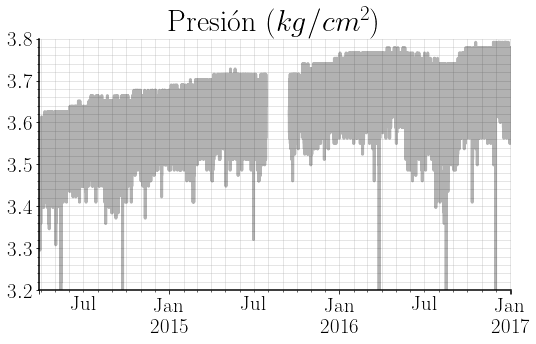

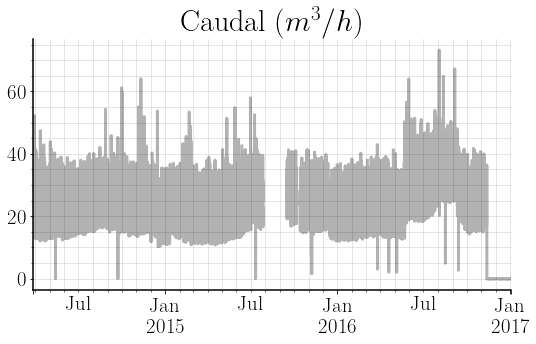

In [17]:
fig, ax = plt.subplots()

ax = dt.loc[:'2017-01-01', 'P'].plot(color = 'black', legend = False, alpha = 0.3, ax = ax)
ax.set_ylim(3.2, 3.8)
ax.set_title('Presión ($kg/cm^2$)')
ax.set_xlabel('')

fig2, ax2 = plt.subplots()
dt.loc[:'2017-01-01', 'Q'].plot(color = 'black', legend = False, alpha = 0.3, ax = ax2)
ax2.set_title('Caudal ($m^3/h$)')
ax2.set_xlabel('')

fig.savefig(fig_dir + 'presion_total')
fig2.savefig(fig_dir + 'caudal_total')


La representación de todos los datos en orden nos revela una tendencia creciente en la variable de la presión (figura superior), aparecen también ventanas sin datos (que se decidieron eliminar al principio de este documento). Aunque el caudal no revele una tendencia a lo largo de los años, podemos ver a partir de abril de 2016, los datos se ven alterados, la tendencia de la presión desaparece.

## Secuencia diaria <a id='diaria'></a>

<div class = "alert alert-block alert-info">
Las siguientes figuras se obtienen de la secuencia original de los datos.
</div>

Procedemos a agrupar los datos en vectores de 24 elementos (uno por cada hora del día). Cada fila corresponde a una fecha y cada columna a una hora de una de las variables.

In [16]:
dt_D_all = dt.groupby([dt.index.date, dt.index.hour]).mean() # Haya la media de los registros en cada hora
dt_D_all.index.set_names(['fecha', 'hora'], inplace = True)

dt_D_all.columns = dt_D_all.columns.droplevel(level = 'unit')
dt_D_all = dt_D_all.unstack(level = 'hora')
dt_D_all.index = pd.to_datetime(dt_D_all.index)

Representamos todos los datos:

Text(0, 0.5, 'Caudal ($m^3/h$)')

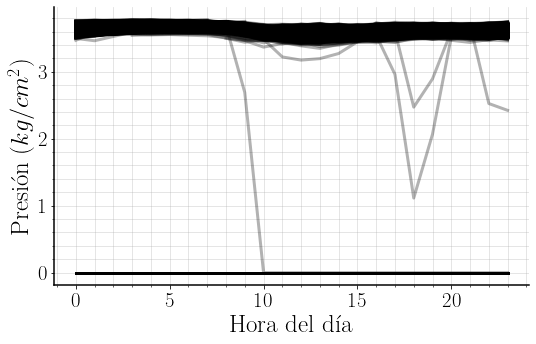

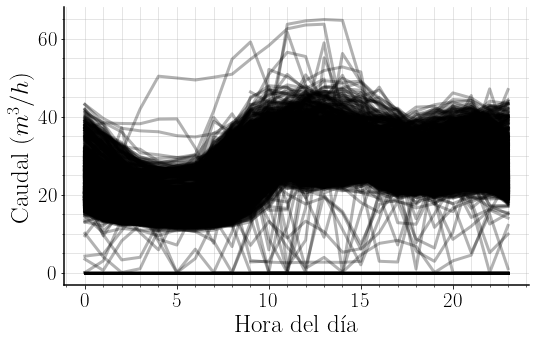

In [14]:

fig1, ax1 = plt.subplots()
dt_D_all.loc['2014':'2020', 'P'].transpose().plot(
    color = 'black', legend = False, alpha = 0.3, ax = ax1)
ax1.set_ylabel('Presión ($kg/cm^2$)')
ax1.set_xlabel('Hora del día')


fig2, ax2 = plt.subplots()
dt_D_all.loc['2014':'2020', 'Q'].transpose().plot(
    color = 'black', legend = False, alpha = 0.3, ax = ax2)
ax2.set_xlabel('Hora del día')
ax2.set_ylabel('Caudal ($m^3/h$)')

Encontramos en ambas variales que una cantidad significante de los datos están a 0. 
El 0 en los datos indica que no ha sido registrada para ese momento debido a reparaciones del sistema.
Procedemos a la eliminación de registros que tengan algún dato no válido (`np.nan`) o algún valor sea 0 (independiente de qué variable proceda, eliminamos el dato entero).

In [17]:
dias_total = dt_D_all.shape[0]
dt_D_all.replace({0 : np.nan}, inplace = True)
dt_D_all.dropna(axis = 0, how = 'any', inplace = True)

Descartamos las series que estén incompletas. El interés de estudiar el perfil del consumo diario se obstaculiza cuando proponemos entradas incompletas.

In [16]:
print('Series temporales completas:', round(dt_D_all.shape[0]/dias_total*100, 1), '%')
print('Número de registros útiles:', dt_D_all.shape[0])

Series temporales completas: 40.1 %
Número de registros útiles: 823


Estamos descartando casi el $60\%$ de todos los datos. Encontramos a partir del día 14 de enero de 2017 que no hay lecturas de presion en los datos. Por otra parte, durante el 12 de noviembre de 2016 y el 13 de enero de 2017, no hay registros del caudal.

Text(0, 0.5, 'Caudal ($m^3/h$)')

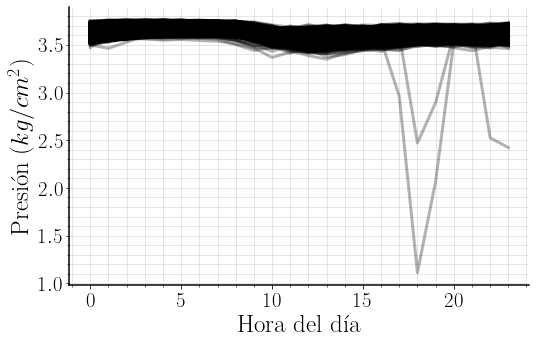

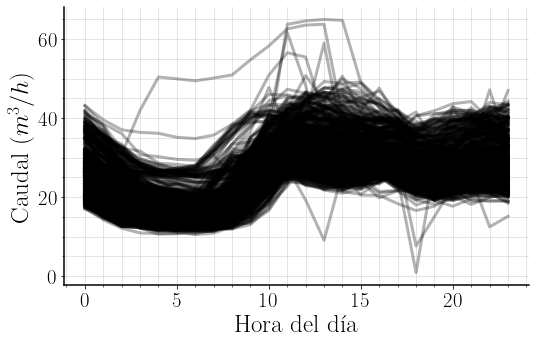

In [18]:
fig1, ax1 = plt.subplots()
dt_D_all.loc['2014':'2020', 'P'].transpose().plot(
    color = 'black', legend = False, alpha = 0.3, ax = ax1)
ax1.set_ylabel('Presión ($kg/cm^2$)')
ax1.set_xlabel('Hora del día')


fig2, ax2 = plt.subplots()
dt_D_all.loc['2014':'2020', 'Q'].transpose().plot(
    color = 'black', legend = False, alpha = 0.3, ax = ax2)
ax2.set_xlabel('Hora del día')
ax2.set_ylabel('Caudal ($m^3/h$)')

## Matriz de distancias <a id="matriz_distancia"></a>

<div class = "alert alert-block alert-info">
El primer bloque es el único que requiere de los datos originales.
</div>

Creamos la matriz de distancias con la métrica de _dtw_ y euclídea. Definimos una función que aprovecha la propiedad que esta matriz es simétrica.

In [20]:
scaler = tsScaler(mu = 0., std = 1.)
P_fitted_all = scaler.fit_transform(dt_D_all['P'])
P_fitted_all = pd.DataFrame(P_fitted_all[:,:,0], index = dt_D_all.index, columns = dt_D_all['P'].columns)

Q_fitted_all = scaler.fit_transform(dt_D_all['Q'])
Q_fitted_all = pd.DataFrame(Q_fitted_all[:,:,0], index = dt_D_all.index, columns = dt_D_all['Q'].columns)

PQ_fitted_all = scaler.fit_transform(dt_D_all.values.reshape( (-1,24,2), order = 'F'))
PQ_fitted_all = pd.DataFrame(PQ_fitted_all.reshape((-1, 48), order = 'F'), index = dt_D_all.index)

In [21]:
def distances(data, scalar_product, **args):
    dd = np.zeros([data.shape[0], data.shape[0]])
    xx, yy = np.triu_indices(data.shape[0])

    i = 0
    for x,y in zip(*[xx,yy]):
        dd[x,y] = scalar_product(data.iloc[x], data.iloc[y], **args)
        if x == y:
            dd[x,y] /= 2.
        i += 1
        if (i == np.round(len(xx)*np.linspace(0,1,11))).any():
            print(np.round(i/len(xx)*100, 1), '%')# Imprimimos el progreso del cálculo

    print("¡Completado!")
    dd += dd.T
    return dd

In [98]:
dd_P_eucl = np.sqrt(distances(P_fitted_all, boss))
dd_Q_eucl = np.sqrt(distances(Q_fitted_all, boss))

10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
100.0 %
¡Completado!
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
100.0 %
¡Completado!


In [106]:
dd_P_dtw = distances(P_fitted_all, dtw, global_constraint="itakura", itakura_max_slope=2.)
dd_Q_dtw = distances(Q_fitted_all, dtw, global_constraint="itakura", itakura_max_slope=2.)

10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
100.0 %
¡Completado!
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
100.0 %
¡Completado!


In [107]:
dd_P_gak = -np.log(distances(P_fitted_all, gak, sigma = 1.))
dd_Q_gak = -np.log(distances(Q_fitted_all, gak, sigma = 1.))

10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
100.0 %
¡Completado!
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
100.0 %
¡Completado!


In [109]:
np.savetxt(fname = dist_dir + 'dd_P_eucl.txt', X = dd_P_eucl)
np.savetxt(fname = dist_dir + 'dd_Q_eucl.txt', X = dd_Q_eucl)

np.savetxt(fname = dist_dir + 'dd_P_dtw.txt', X = dd_P_dtw)
np.savetxt(fname = dist_dir + 'dd_Q_dtw.txt', X = dd_Q_dtw)

np.savetxt(fname = dist_dir + 'dd_P_gak.txt', X = dd_P_gak)
np.savetxt(fname = dist_dir + 'dd_Q_gak.txt', X = dd_Q_gak)

Para ahorrar memoria, cargamos las distancias de las distintas variables y métricas. Como muchos de los algoritmos emplean las distancia entre los datos, esto agiliza el proceso considerablemente.

In [12]:
dd_P_eucl = np.loadtxt(fname = dist_dir + 'dd_P_eucl.txt')
dd_Q_eucl = np.loadtxt(fname = dist_dir + 'dd_Q_eucl.txt')

dd_P_dtw = np.loadtxt(fname = dist_dir + 'dd_P_dtw.txt')
dd_Q_dtw = np.loadtxt(fname = dist_dir + 'dd_Q_dtw.txt')

dd_P_gak = np.loadtxt(fname = dist_dir + 'dd_P_gak.txt')
dd_Q_gak = np.loadtxt(fname = dist_dir + 'dd_Q_gak.txt')

Calculamos la distancia entre cada dato (considerando dato como todos los valores de caudal y presión recogidos en un día con frecuencia de una hora).

In [22]:
dd_eucl = np.sqrt(dd_P_eucl**2 + dd_Q_eucl**2)
dd_dtw = np.sqrt(dd_P_dtw**2 + dd_Q_dtw**2)
dd_gak = dd_P_gak + dd_Q_gak

Para configurar una medida de distancia uniendo ambas variables, consideramos la sumas de las distancias cuadráticas de cada método. Se puede entender que dentro de los algoritmos de búsqueda del mejor recorrido para minimizar la distancia concatenamos la serie que describe la presión con la que describe el caudal y forzamos que el recorrido elegido salte del último elemento de una de las series con la primera de la otra.
Para el caso del `gak`, la suma de las distancias cuadráticas es equivalente al producto de elemento por elemento del kernel (matriz de similitud) de cada variable o la suma de la distancia equivalente (lo que se calcula en el bloque anterior).

---

## Serie temporal representativa <a id = "serie_temporal_representativa">

<div class = "alert alert-block alert-info">
Las siguientes figuras se obtienen de la secuencia original de los datos.
</div>

Buscamos la serie temporal representativa hayando la media de cada hora. Representando cada variable en una figura distinta, obtenemos los siguientes resultados:

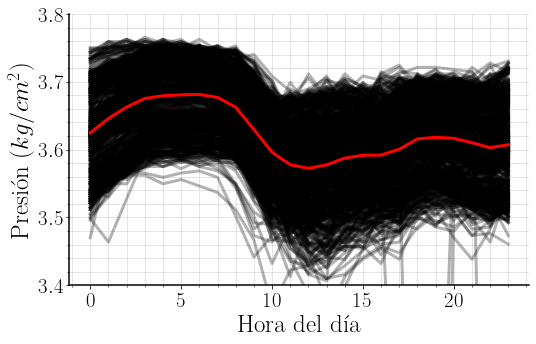

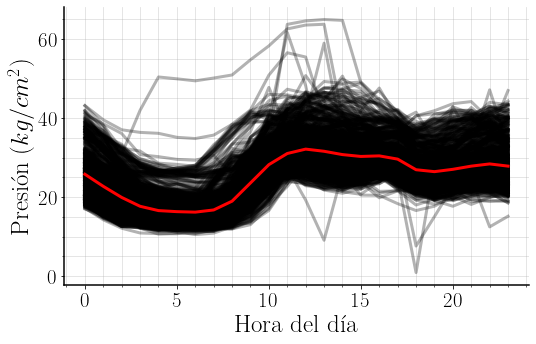

In [22]:
fig_P, ax_P = plt.subplots()
fig_Q, ax_Q = plt.subplots()

ax_P.set_ylim(3.4, 3.8)

dt_D_all.loc['2014':'2020', 'P'].transpose().plot(
    color = 'black', legend = False, alpha = 0.3, ax = ax_P)
dt_D_all['P'].mean(axis = 0).plot(c = 'r', lw = 3, ax = ax_P)

dt_D_all.loc['2014':'2020', 'Q'].transpose().plot(
    color = 'black', legend = False, alpha = 0.3, ax = ax_Q)
dt_D_all['Q'].mean(axis = 0).plot(c = 'r', lw = 3, ax = ax_Q)

ax_P.set_ylabel('Presión ($kg/cm^2$)')
ax_P.set_xlabel('Hora del día')
ax_Q.set_ylabel('Presión ($kg/cm^2$)')
ax_Q.set_xlabel('Hora del día')

fig_P.savefig(fig_dir + "ciclos_P.pdf")
fig_Q.savefig(fig_dir + "ciclos_Q.pdf")

Evaluamos las distancias de cada secuencia a la media (utilizando la métrica de Euler). Para conocer la distribución de datos según la distancia la media.

In [23]:
mean_P = scaler.fit_transform(dt_D_all['P'].mean(axis = 0).values.reshape(1,-1)).reshape(1,-1)
mean_Q = scaler.fit_transform(dt_D_all['Q'].mean(axis = 0).values.reshape(1,-1)).reshape(1,-1)

mean_dist_P_eucl = np.sqrt(sci.spatial.distance.cdist(P_fitted_all, mean_P, metric = boss))
mean_dist_Q_eucl = np.sqrt(sci.spatial.distance.cdist(Q_fitted_all, mean_Q, metric = boss))
mean_dist_P_dtw = sci.spatial.distance.cdist(P_fitted_all, mean_P, metric = dtw, global_constraint="itakura", itakura_max_slope=2.)
mean_dist_Q_dtw = sci.spatial.distance.cdist(Q_fitted_all, mean_Q, metric = dtw, global_constraint="itakura", itakura_max_slope=2.)
mean_dist_P_gak = -np.log(sci.spatial.distance.cdist(P_fitted_all, mean_P, metric = gak, sigma = 1.))
mean_dist_Q_gak = -np.log(sci.spatial.distance.cdist(Q_fitted_all, mean_Q, metric = gak, sigma = 1.))

mean_dist_eucl = np.sqrt(mean_dist_P_eucl**2 + mean_dist_Q_eucl**2)
mean_dist_dtw = np.sqrt(mean_dist_P_dtw**2 + mean_dist_Q_dtw**2)
mean_dist_gak = mean_dist_P_gak + mean_dist_Q_gak

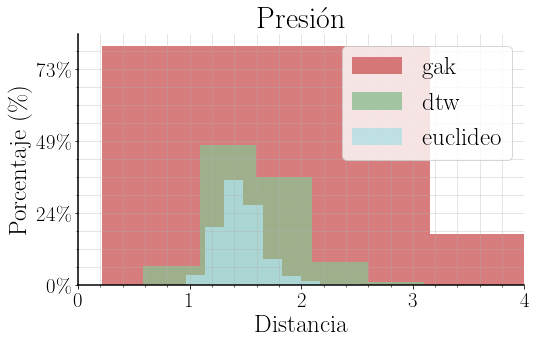

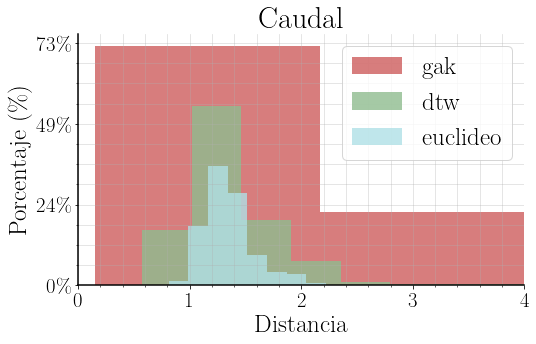

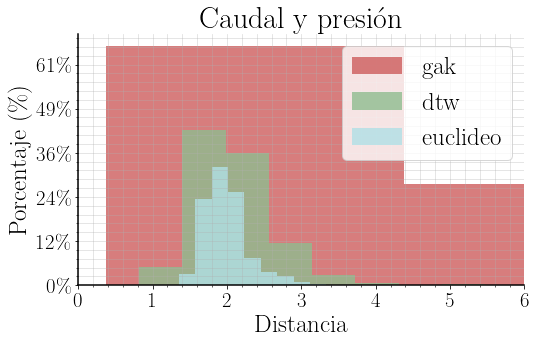

In [62]:
fig_P, ax_P = plt.subplots()
fig_Q, ax_Q = plt.subplots()
fig_PQ, ax_PQ = plt.subplots()

labels = ['gak', 'dtw', 'euclideo']
factor = [1,1,1]
for i, ll in enumerate([mean_dist_P_gak, mean_dist_P_dtw, mean_dist_P_eucl]):
    ax_P.hist(ll, alpha = 0.8, density = False, label = labels[i])
ax_P.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax = dt_D_all.shape[0]))
ax_P.set_title('Presión')
ax_P.set_xlabel('Distancia')
ax_P.set_ylabel('Porcentaje (\%)')
ax_P.set_xlim(0, 4)
ax_P.legend()

for i, ll in enumerate([mean_dist_Q_gak, mean_dist_Q_dtw, mean_dist_Q_eucl]):
    ax_Q.hist(ll, alpha = 0.8, density = False, label = labels[i])
ax_Q.set_title('Caudal')
ax_Q.set_xlabel('Distancia')
ax_Q.set_ylabel('Porcentaje (\%)')
ax_Q.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax = dt_D_all.shape[0]))
ax_Q.set_xlim(0, 4)
ax_Q.legend()


for i, ll in enumerate([mean_dist_gak, mean_dist_dtw, mean_dist_eucl]):
    ax_PQ.hist(ll, alpha = 0.8, density = False, label = labels[i])
ax_PQ.set_title('Caudal y presión')
ax_PQ.set_xlabel('Distancia')
ax_PQ.set_ylabel('Porcentaje (\%)')
ax_PQ.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax = dt_D_all.shape[0]))
ax_PQ.set_xlim(0, 6)
ax_PQ.legend()

fig_P.savefig(fig_dir + 'distro_P.pdf')
fig_Q.savefig(fig_dir + 'distro_Q.pdf')
fig_PQ.savefig(fig_dir + 'distro_PQ.pdf')

plt.show()

Obtenemos que las distribuciones de las distancias entre datos se conforman a una distribución $\chi^2$. Esto demuestra una distribución normal de los datos alrededor de las medias. La diferencia entre las distintas métricas se debe a las varianzas. La métrica euclídea tiene menor capacidad de distinguir dos series temporales que dtw o gak.

## Detección y eliminación de outliers (manual) <a id = 'outliers_manual'></a>

<div class = "alert alert-block alert-info">
La eliminación de anomalías se realiza a los datos originales. Sólo el primer bloque los requiere.
</div>

Procedemos a la eliminación de outliers que destaquen en las representaciones visuales del apartado anterior.
Las series outliers serán aquellas en donde uno o más de sus puntos se encuentren comprendidos dentro de un rectángulo cuya forma y posición será elegida manualmente.
Esta forma de eliminación de outliers será un método inicial para conocer mejor la forma de los datos sin irregularidades.

Text(0, 0.5, 'Caudal ($m^3/h$)')

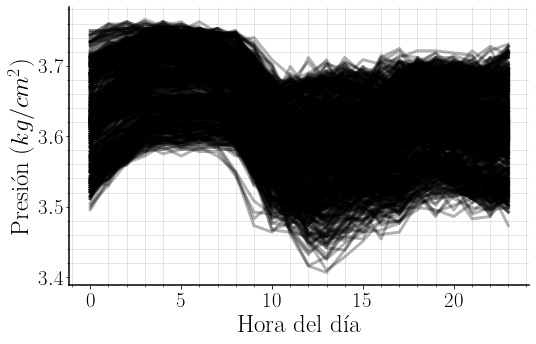

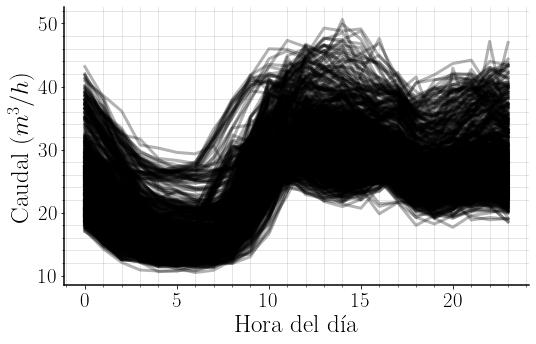

In [36]:
color_disc = ['r', 'k']

# Construimos una másquara que elige los elementos que son outliers
# Outliers para la presión
dt_DP_outliers = (dt_D_all.loc[:,'P'] < 3.0).any(axis = 1)
dt_DP_outliers |= (dt_D_all.loc[:,'P'].loc[:,10:14] < 3.4).any(axis = 1)
dt_DP_outliers |= (dt_D_all.loc[:,'P'].loc[:,20:22] < 3.48).any(axis = 1)
dt_DP_outliers |= (dt_D_all.loc[:,'P'].loc[:,9:11] < 3.46).any(axis = 1)

# Outliers para el caudal
dt_DQ_outliers = (dt_D_all.loc[:,'Q'] > 55.0).any(axis = 1)
dt_DQ_outliers |= (dt_D_all.loc[:,'Q'].loc[:,12:] < 14).any(axis = 1)
dt_DQ_outliers |= (dt_D_all.loc[:,'Q'].loc[:,5:6] > 30).any(axis = 1)
dt_DQ_outliers |= (dt_D_all.loc[:,'Q'].loc[:,11:13] > 50).any(axis = 1)
dt_DQ_outliers |= (dt_D_all.loc[:,'Q'].loc[:,17:20] < 17.5).any(axis = 1)

# Combinamos los outliers detectados tanto en la variable de presión como en la de caudal
dt_D_outliers = dt_DP_outliers | dt_DQ_outliers


ax_P = dt_D_all.loc[~dt_D_outliers, 'P'].transpose().plot(
    c = color_disc[1], legend = False, alpha = 0.3)
ax_P.grid()

ax_Q = dt_D_all.loc[~dt_D_outliers, 'Q'].transpose().plot(
    c = color_disc[1], legend = False, alpha = 0.3)
ax_Q.grid()

ax_P.set_xlabel('Hora del día')
ax_P.set_ylabel('Presión ($kg/cm^2$)')

ax_Q.set_xlabel('Hora del día')
ax_Q.set_ylabel('Caudal ($m^3/h$)')

Observamos que las líneas en los ejes de coordenadas han desaparecido.

Eliminamos los outliers:

In [27]:
dt_D = dt_D_all[~dt_D_outliers]

Obtenemos las formas de las series normalizadas:

In [28]:
P_fitted_all[~dt_D_outliers]

0         1         2         3         4         5  \
fecha                                                                    
2014-04-01  0.816043  0.903331  1.595408  1.335620  1.509160  1.162082   
2014-04-02  0.486657  0.816220  1.392462  1.227680  1.473372  1.226694   
2014-04-03  0.174974  1.125031  1.125031  1.695291  1.410161  1.504825   
2014-04-04  0.561215  0.815063  1.238481  1.575589  1.238481  1.407035   
2014-04-06  0.112402  0.449204  0.920081  1.055771  1.122807  1.256073   
...              ...       ...       ...       ...       ...       ...   
2016-11-07  1.367341  1.366443  1.441061  1.442858  1.441959  1.441959   
2016-11-08  0.761665  1.321243  0.986842  1.434505  1.323935  1.661028   
2016-11-09  1.002986  1.102278  1.402543  1.799711  1.700419  1.202765   
2016-11-10  0.971908  1.442968  1.444100  1.254996  1.632072  1.254996   
2016-11-11  0.959959  1.223253  1.486547  1.662428  1.310669  1.310667   

                   6         7         8         9  ...        14        15  \
fecha                                               ...                       
2014-04-01  1.508121  1.162080  0.556252 -0.571232  ... -0.917271 -1.003523   
2014-04-02  1.391474  1.390487  0.404758 -1.321995  ... -0.995390 -0.911519   
2014-04-03  1.315497  1.314357  0.268497 -1.251819  ... -0.489949 -1.157155   
2014-04-04  1.407035  1.491312  0.475922 -1.471599  ... -0.625776 -0.709038   
2014-04-06  1.122808  1.323918  0.920888  0.988733  ... -1.234807 -1.369690   
...              ...       ...       ...       ...  ...       ...       ...   
2016-11-07  1.291825  0.342773 -0.356956 -1.032112  ... -0.731843 -0.806460   
2016-11-08  1.210673 -0.850993 -1.600691 -1.151683  ... -1.038419 -0.926501   
2016-11-09  1.102278  0.270861 -0.891931 -1.291490  ...  0.006481 -1.091711   
2016-11-10  1.065894  0.028278 -2.049217 -0.633775  ... -0.633775 -1.199951   
2016-11-11  1.134787 -0.386708 -2.289099 -0.972627  ... -1.058986 -0.796745   

                  16        17        18        19        20        21  \
fecha                                                                    
2014-04-01 -1.263313 -0.743733 -0.396655  0.035636  0.122924 -0.396655   
2014-04-02 -1.405864 -0.500057  0.240963  0.322860  0.158080 -0.582942   
2014-04-03 -1.251819 -0.110156 -0.111294  0.173836  0.080311 -0.681556   
2014-04-04 -1.047164 -0.538455 -0.539467 -0.116051 -0.200329 -0.370912   
2014-04-06 -1.301844 -1.099924 -0.426320 -0.157362  0.314321  0.111595   
...              ...       ...       ...       ...       ...       ...   
2016-11-07 -0.957495 -0.131305 -0.282339 -0.132204 -0.432473 -0.582608   
2016-11-08  0.311306 -0.139051  0.421875 -0.364231  0.086128 -1.263596   
2016-11-09 -0.792641 -0.592858  0.206261 -0.893129 -0.692152 -1.589364   
2016-11-10  0.404599 -0.066463  0.027523 -0.255567 -0.727761 -0.538657   
2016-11-11 -0.444984  0.169022 -0.005807  0.258541 -0.269102 -0.533450   

                  22        23  
fecha                           
2014-04-01 -1.090813 -0.136866  
2014-04-02 -0.170496 -0.171481  
2014-04-03 -1.252959 -0.015492  
2014-04-04 -0.115036 -0.117066  
2014-04-06  0.044558  0.045365  
...              ...       ...  
2016-11-07 -0.881977  0.617570  
2016-11-08 -0.250967  0.760316  
2016-11-09 -0.193300  0.604624  
2016-11-10 -0.821745  0.782805  
2016-11-11  0.082661  0.345956  

[798 rows x 24 columns]

In [29]:
P_fitted = P_fitted_all[~dt_D_outliers]
Q_fitted = Q_fitted_all[~dt_D_outliers]
PQ_fitted = PQ_fitted_all[~dt_D_outliers]

In [30]:
dd_P_eucl_all = dd_P_eucl
dd_Q_eucl_all = dd_Q_eucl

dd_P_dtw_all = dd_P_dtw
dd_Q_dtw_all = dd_Q_dtw

dd_P_gak_all = dd_P_gak
dd_Q_gak_all = dd_Q_gak

dd_eucl_all = dd_eucl
dd_dtw_all = dd_dtw
dd_gak_all = dd_gak

In [31]:
dd_P_eucl = dd_P_eucl_all[~dt_D_outliers,:][:,~dt_D_outliers]
dd_Q_eucl = dd_Q_eucl_all[~dt_D_outliers,:][:,~dt_D_outliers]

dd_P_dtw = dd_P_dtw_all[~dt_D_outliers,:][:,~dt_D_outliers]
dd_Q_dtw = dd_Q_dtw_all[~dt_D_outliers,:][:,~dt_D_outliers]

dd_P_gak = dd_P_gak_all[~dt_D_outliers,:][:,~dt_D_outliers]
dd_Q_gak = dd_Q_gak_all[~dt_D_outliers,:][:,~dt_D_outliers]

dd_eucl = dd_eucl_all[~dt_D_outliers,:][:,~dt_D_outliers]
dd_dtw = dd_dtw_all[~dt_D_outliers,:][:,~dt_D_outliers]
dd_gak = dd_gak_all[~dt_D_outliers,:][:,~dt_D_outliers]

## Dependencia entre las variables <a id="dependencias"></a>

<div class = "alert alert-block alert-info">
Las siguientes figuras se obtienen de la secuencia original de los datos.
</div>

Representamos los datos en función de la presión y caudal. Buscamos patrones que sean visibles.

C:\Users\jalonso\Anaconda3\envs\mountain\lib\site-packages\ipykernel_launcher.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


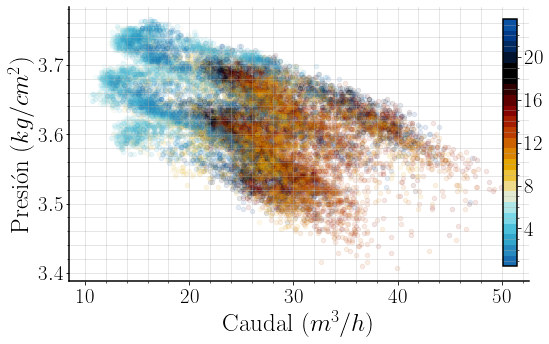

In [155]:
fig, ax = plt.subplots()

for i in np.arange(23,0,-1):
    dt_D.xs(i, axis = 1, level = 1).plot.scatter(x = 'Q', y = 'P', alpha = 0.1, ax = ax, color = [color_mpl[i]])
    
ax.set_xlabel('Caudal ()')
ax.set_ylabel('Presión ()')


norm = mpl.colors.Normalize(vmin=0,vmax=24)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbaxes = inset_axes(ax, width="3%", height="90%", loc=1)
cbar = plt.colorbar(sm, ticks=np.arange(0,24,4), 
             boundaries=np.arange(0.5,24,1), ax = ax,
             cax = cbaxes)

ax.set_xlabel('Caudal ($m^3/h$)')
ax.set_ylabel('Presión ($kg/cm^2$)')


fig.savefig(fig_dir + 'PvsQ')

Observamos que el avance de las horas produce una presión y caudal distintos de forma que podemos distinguir regiones predominantes por las horas de la mañana y de la noche.

### Distinción entre días festivos y laborales <a id = "dependencias_laboralFestivo"></a>

Diferenciamos entre días laborales y festivos utilizando códigos de colores:

Text(0, 0.5, 'Presión ($kg/cm^2$)')

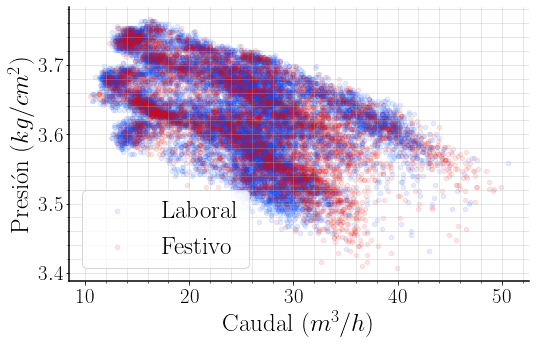

In [138]:
week = dt_D.index.dayofweek < 5 # L-V: Laboral S-D: Festivo
fig, ax = plt.subplots()

dt_D[week].stack('hora').plot.scatter(x = 'Q', y = 'P', alpha = 0.1, ax = ax, color = color(0.2), label = 'Laboral')
dt_D[~week].stack('hora').plot.scatter(x = 'Q', y = 'P', alpha = 0.1, ax = ax, color = color(.9), label = 'Festivo')

ax.legend()

ax.set_xlabel('Caudal ($m^3/h$)')
ax.set_ylabel('Presión ($kg/cm^2$)')

En primera instancia no aparece haber diferencias en regiones del espacio debido al tipo de día de la semana. Es importante denotar que la densidad de los días festivos es muy inferior (2 días por cada 5 laborales) por lo que puede aparentar que se concentra en regiones. La zona más notable es la cola en la parte inferior derecha donde aparecen más datos festivos que laborales.

### Distinción entre los días de la semana <a id = "dependencias_diasDeSemana"></a>

Codificamos los días de la semana en distintos colores:

Text(0, 0.5, 'Presión ($kg/cm^2$)')

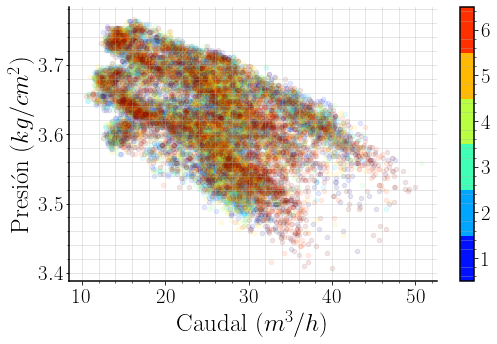

In [139]:
mpl.style.use('fast')
fig, ax = plt.subplots()


for i in np.arange(7):
    mask = dt_D.index.dayofweek == i
    dt_D[mask].stack('hora').plot.scatter(x = 'Q', y = 'P', alpha = 0.1, ax = ax, color = color(i/6))
    

norm = mpl.colors.Normalize(vmin=0,vmax=7)
sm = plt.cm.ScalarMappable(cmap=color, norm=norm)
sm.set_array([])
plt.colorbar(sm, ticks=np.linspace(0,6,7), 
             boundaries=np.arange(0.5,7,1))

ax.set_xlabel('Caudal ($m^3/h$)')
ax.set_ylabel('Presión ($kg/cm^2$)')

No observamos zonas relevantes a días de la semana. La disperción de los datos no se debe a la variabilidad semanal del consumo de agua.

# Reducción de la dimensionalidad

## Shapelets <a id = "shapelets"></a>

Buscamos los shapelets que definen la forma de las curvas.

In [32]:
st_P = ShapeletTransform(window_sizes='auto',
                       random_state=42, sort=True,
                       n_shapelets = 10,
                       remove_similar = True,
                       verbose = 1,
                      n_jobs = -1)

st_Q = ShapeletTransform(window_sizes='auto',
                       random_state=42, sort=True,
                       n_shapelets = 10,
                       remove_similar = True,
                       verbose = 1,
                      n_jobs = -1)

st_PQ = ShapeletTransform(window_sizes='auto',
                       random_state=42, sort=True,
                       n_shapelets = 10,
                       remove_similar = True,
                       verbose = 1,
                      n_jobs = -1)

In [33]:
y = np.zeros(P_fitted.shape[0])

In [34]:
st_P.fit(P_fitted, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    9.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    9.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    9.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10

ShapeletTransform(n_jobs=-1, n_shapelets=10, random_state=42, sort=True,
                  verbose=1)

In [35]:
st_Q.fit(Q_fitted, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10

ShapeletTransform(n_jobs=-1, n_shapelets=10, random_state=42, sort=True,
                  verbose=1)

In [36]:
st_PQ.fit(PQ_fitted, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   56.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   35.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   38.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   34.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   34.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   35.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10

ShapeletTransform(n_jobs=-1, n_shapelets=10, random_state=42, sort=True,
                  verbose=1)

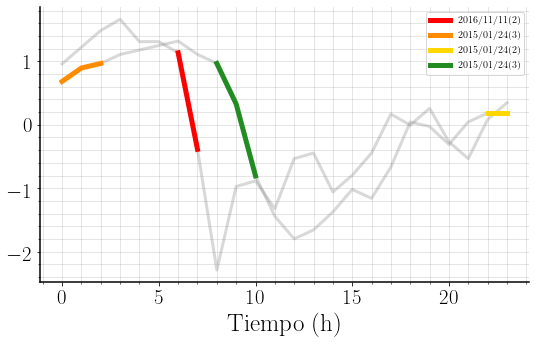

In [297]:
fig, ax = plt.subplots()
for i, idx in enumerate(np.unique(st_P.indices_[:4,0])):
    ax.plot(P_fitted.iloc[idx],
             color = 'grey', alpha = 0.3)

for i, index in enumerate(st_P.indices_[:4]):
    idx, start, end = index
    ax.plot(np.arange(start, end), P_fitted.iloc[idx, start:end],
             lw=5, label= P_fitted.index[idx].strftime('%Y/%m/%d') + '(' + str(end - start) + ')')

ax.set_xlabel('Tiempo (h)')
ax.legend(loc='best', fontsize = 10)

fig.savefig(fig_dir + 'P_shapelet')
plt.show()

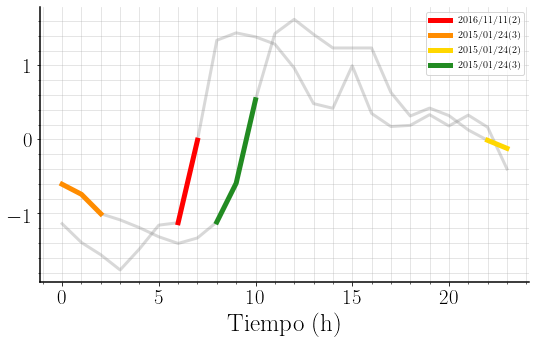

In [298]:
fig, ax = plt.subplots()
for i, idx in enumerate(np.unique(st_Q.indices_[:4,0])):
    ax.plot(Q_fitted.iloc[idx],
             color = 'grey', alpha = 0.3)

for i, index in enumerate(st_Q.indices_[:4]):
    idx, start, end = index
    ax.plot(np.arange(start, end), Q_fitted.iloc[idx, start:end],
             lw=5, label= Q_fitted.index[idx].strftime('%Y/%m/%d') + '(' + str(end - start) + ')')

ax.set_xlabel('Tiempo (h)')
ax.legend(loc='best', fontsize = 10)

fig.savefig(fig_dir + 'Q_shapelet')
plt.show()

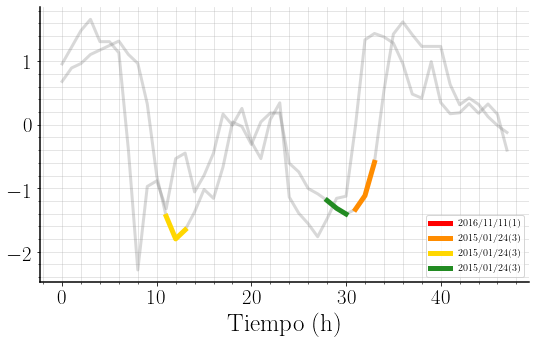

In [299]:
fig, ax = plt.subplots()
for i, idx in enumerate(np.unique(st_PQ.indices_[:4,0])):
    ax.plot(PQ_fitted.iloc[idx],
             color = 'grey', alpha = 0.3)

for i, index in enumerate(st_PQ.indices_[:4]):
    idx, start, end = index
    ax.plot(np.arange(start, end), PQ_fitted.iloc[idx, start:end],
             lw=5, label= PQ_fitted.index[idx].strftime('%Y/%m/%d') + '(' + str(end - start) + ')')

ax.set_xlabel('Tiempo (h)')
ax.legend(loc='best', fontsize = 10)

fig.savefig(fig_dir + 'PQ_shapelet')
plt.show()

Observamos que los shapelets tienen una dimensión muy reducida, compuesta por 3 datos.

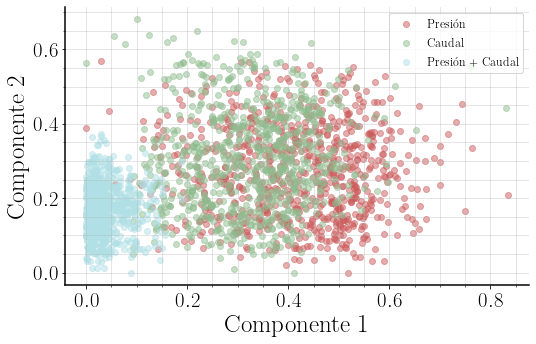

In [46]:
tt_P = st_P.transform(P_fitted)
tt_Q = st_Q.transform(Q_fitted)
tt_PQ = st_PQ.transform(PQ_fitted)
label = ['Presión', 'Caudal', 'Presión + Caudal']


fig, ax = plt.subplots()
for i, data in enumerate([tt_P, tt_Q, tt_PQ]):
    ax.scatter(data[:,0], data[:,1], label = label[i], alpha = 0.5)

ax.set_xlabel('Componente 1')
ax.set_ylabel('Componente 2')
ax.legend(fontsize = 12)



fig.savefig(fig_dir + 'shapelets')

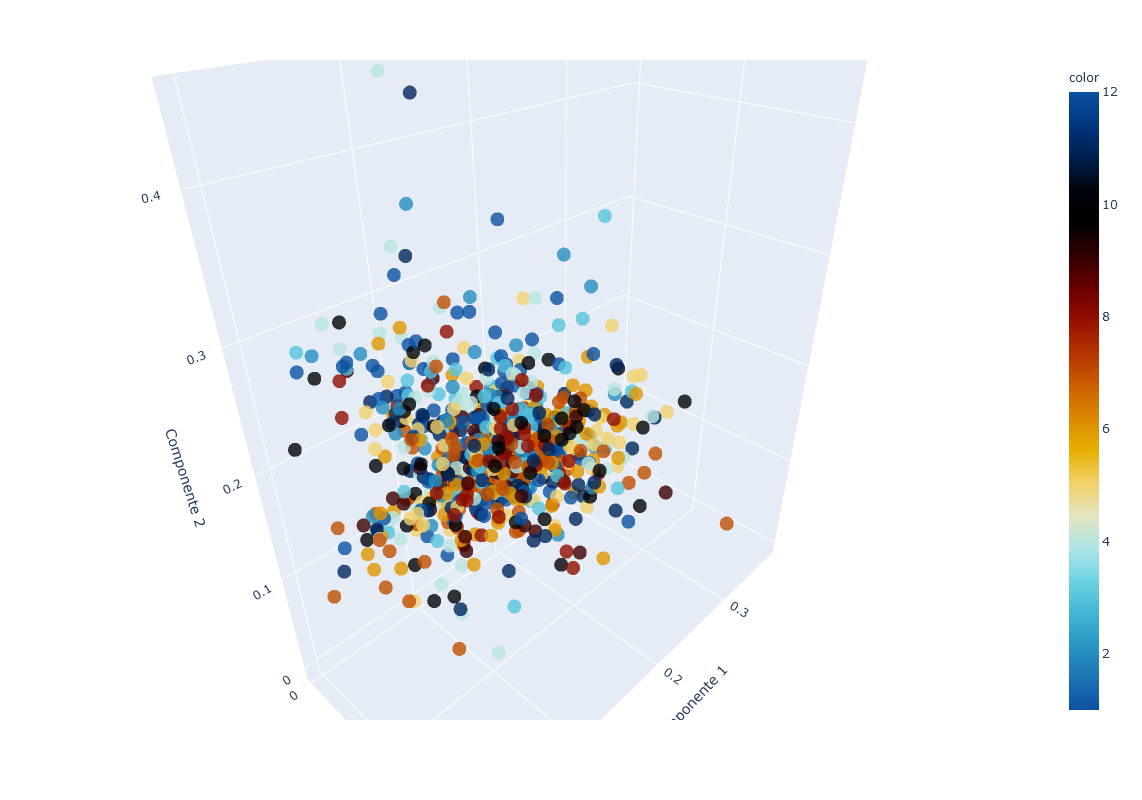

In [302]:
tt_PQ = st_PQ.transform(PQ_fitted)
month = give_drawing(tt_PQ[:,:3], PQ_fitted.index.month.to_series().values, continuous_color = continuous_color_M)

month.show()

La figura no revela mucha información, en especial cuando las formas son muy parecidas en esta representación. En apartados posteriores buscaremos una mejor forma de representar los datos para distinguirlos.

## PCA <a id = "pca"></a>

Aplicamos el método de componentes principales considerando cada variable por separado como vectores en un espacio de 24 dimensiones, y también, ambas variables como si se tratara de un espacio vectorial de 48 dimensiones.

In [48]:
pca = PCA(n_components = 24*2, random_state = 42)
pca.fit(PQ_fitted)

PCA(n_components=48, random_state=42)

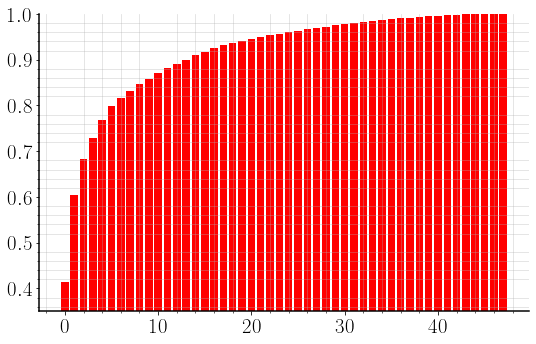

In [36]:
fig, ax = plt.subplots(1,1)

ax.bar(x = np.arange(24*2), height = pca.explained_variance_ratio_.cumsum())
ax.set_ylim(0.35,1)
ax.grid()

In [49]:
pca_PQ = pca.transform(PQ_fitted)
pca_PQ = pd.DataFrame(pca_PQ, index = PQ_fitted.index,
             columns = pd.Index(np.arange(24*2), name = 'PCA'))

### Representación gráfica

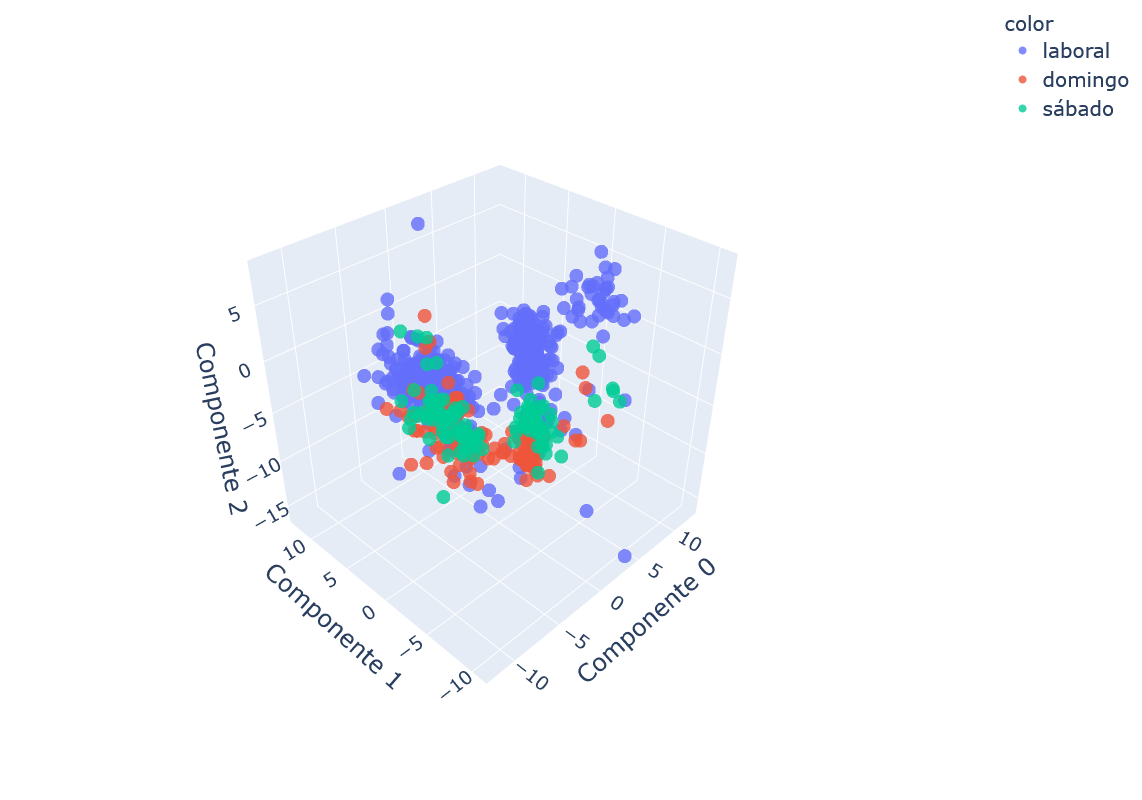

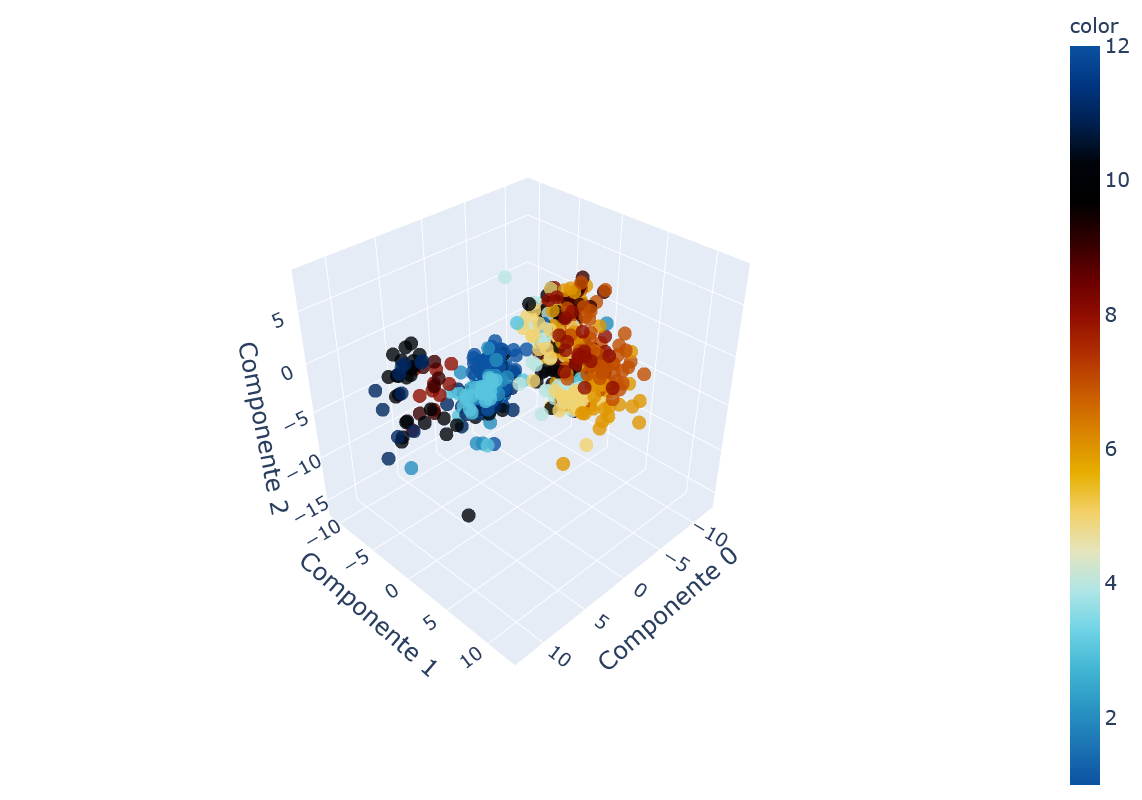

In [114]:
dayweek = give_drawing(pca_PQ, pca_PQ.index.dayofweek.to_series().transform(lambda x: ll_name[ll_repl[ll_filter == x][0]]),
                      x_cam = -1.25, y_cam = -1.25, zoom = 1.4)
month = give_drawing(pca_PQ, pca_PQ.index.month.to_series().values, continuous_color = continuous_color_M, zoom = 1.4)






dayweek.write_image(fig_dir + 'pca_semana.pdf')
month.write_image(fig_dir + 'pca_mes.pdf')

dayweek.show()
month.show()

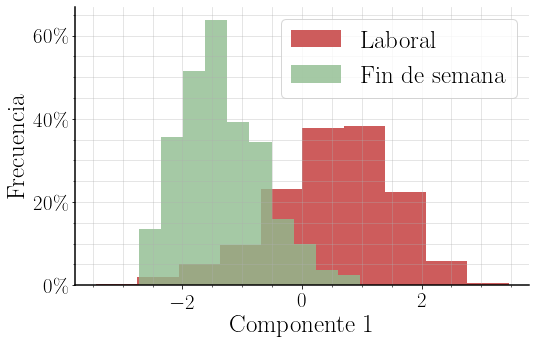

In [51]:
fig, ax = plt.subplots()

mask = pca_PQ.index.dayofweek < 5
pca_PQ.loc[mask,1].hist(ax = ax, density = True, label = "Laboral")
pca_PQ.loc[~mask,1].hist(ax = ax, alpha = 0.8, density = True, label = "Fin de semana")
ax.legend()
ax.set_xlabel('Componente 1')
ax.set_ylabel('Frecuencia')
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax = 1.))

fig.savefig(fig_dir + 'pca_distribucion.pdf')

In [119]:
colors_hist = generate_colors(px.colors.cyclical.IceFire, shift = -2./12., res = 12)
colors_hist = [[float(col.split(',')[0][4:])/256,
 float(col.split(',')[1])/256,
 float(col.split(',')[2][:-1])/256]
 for col in colors_hist]

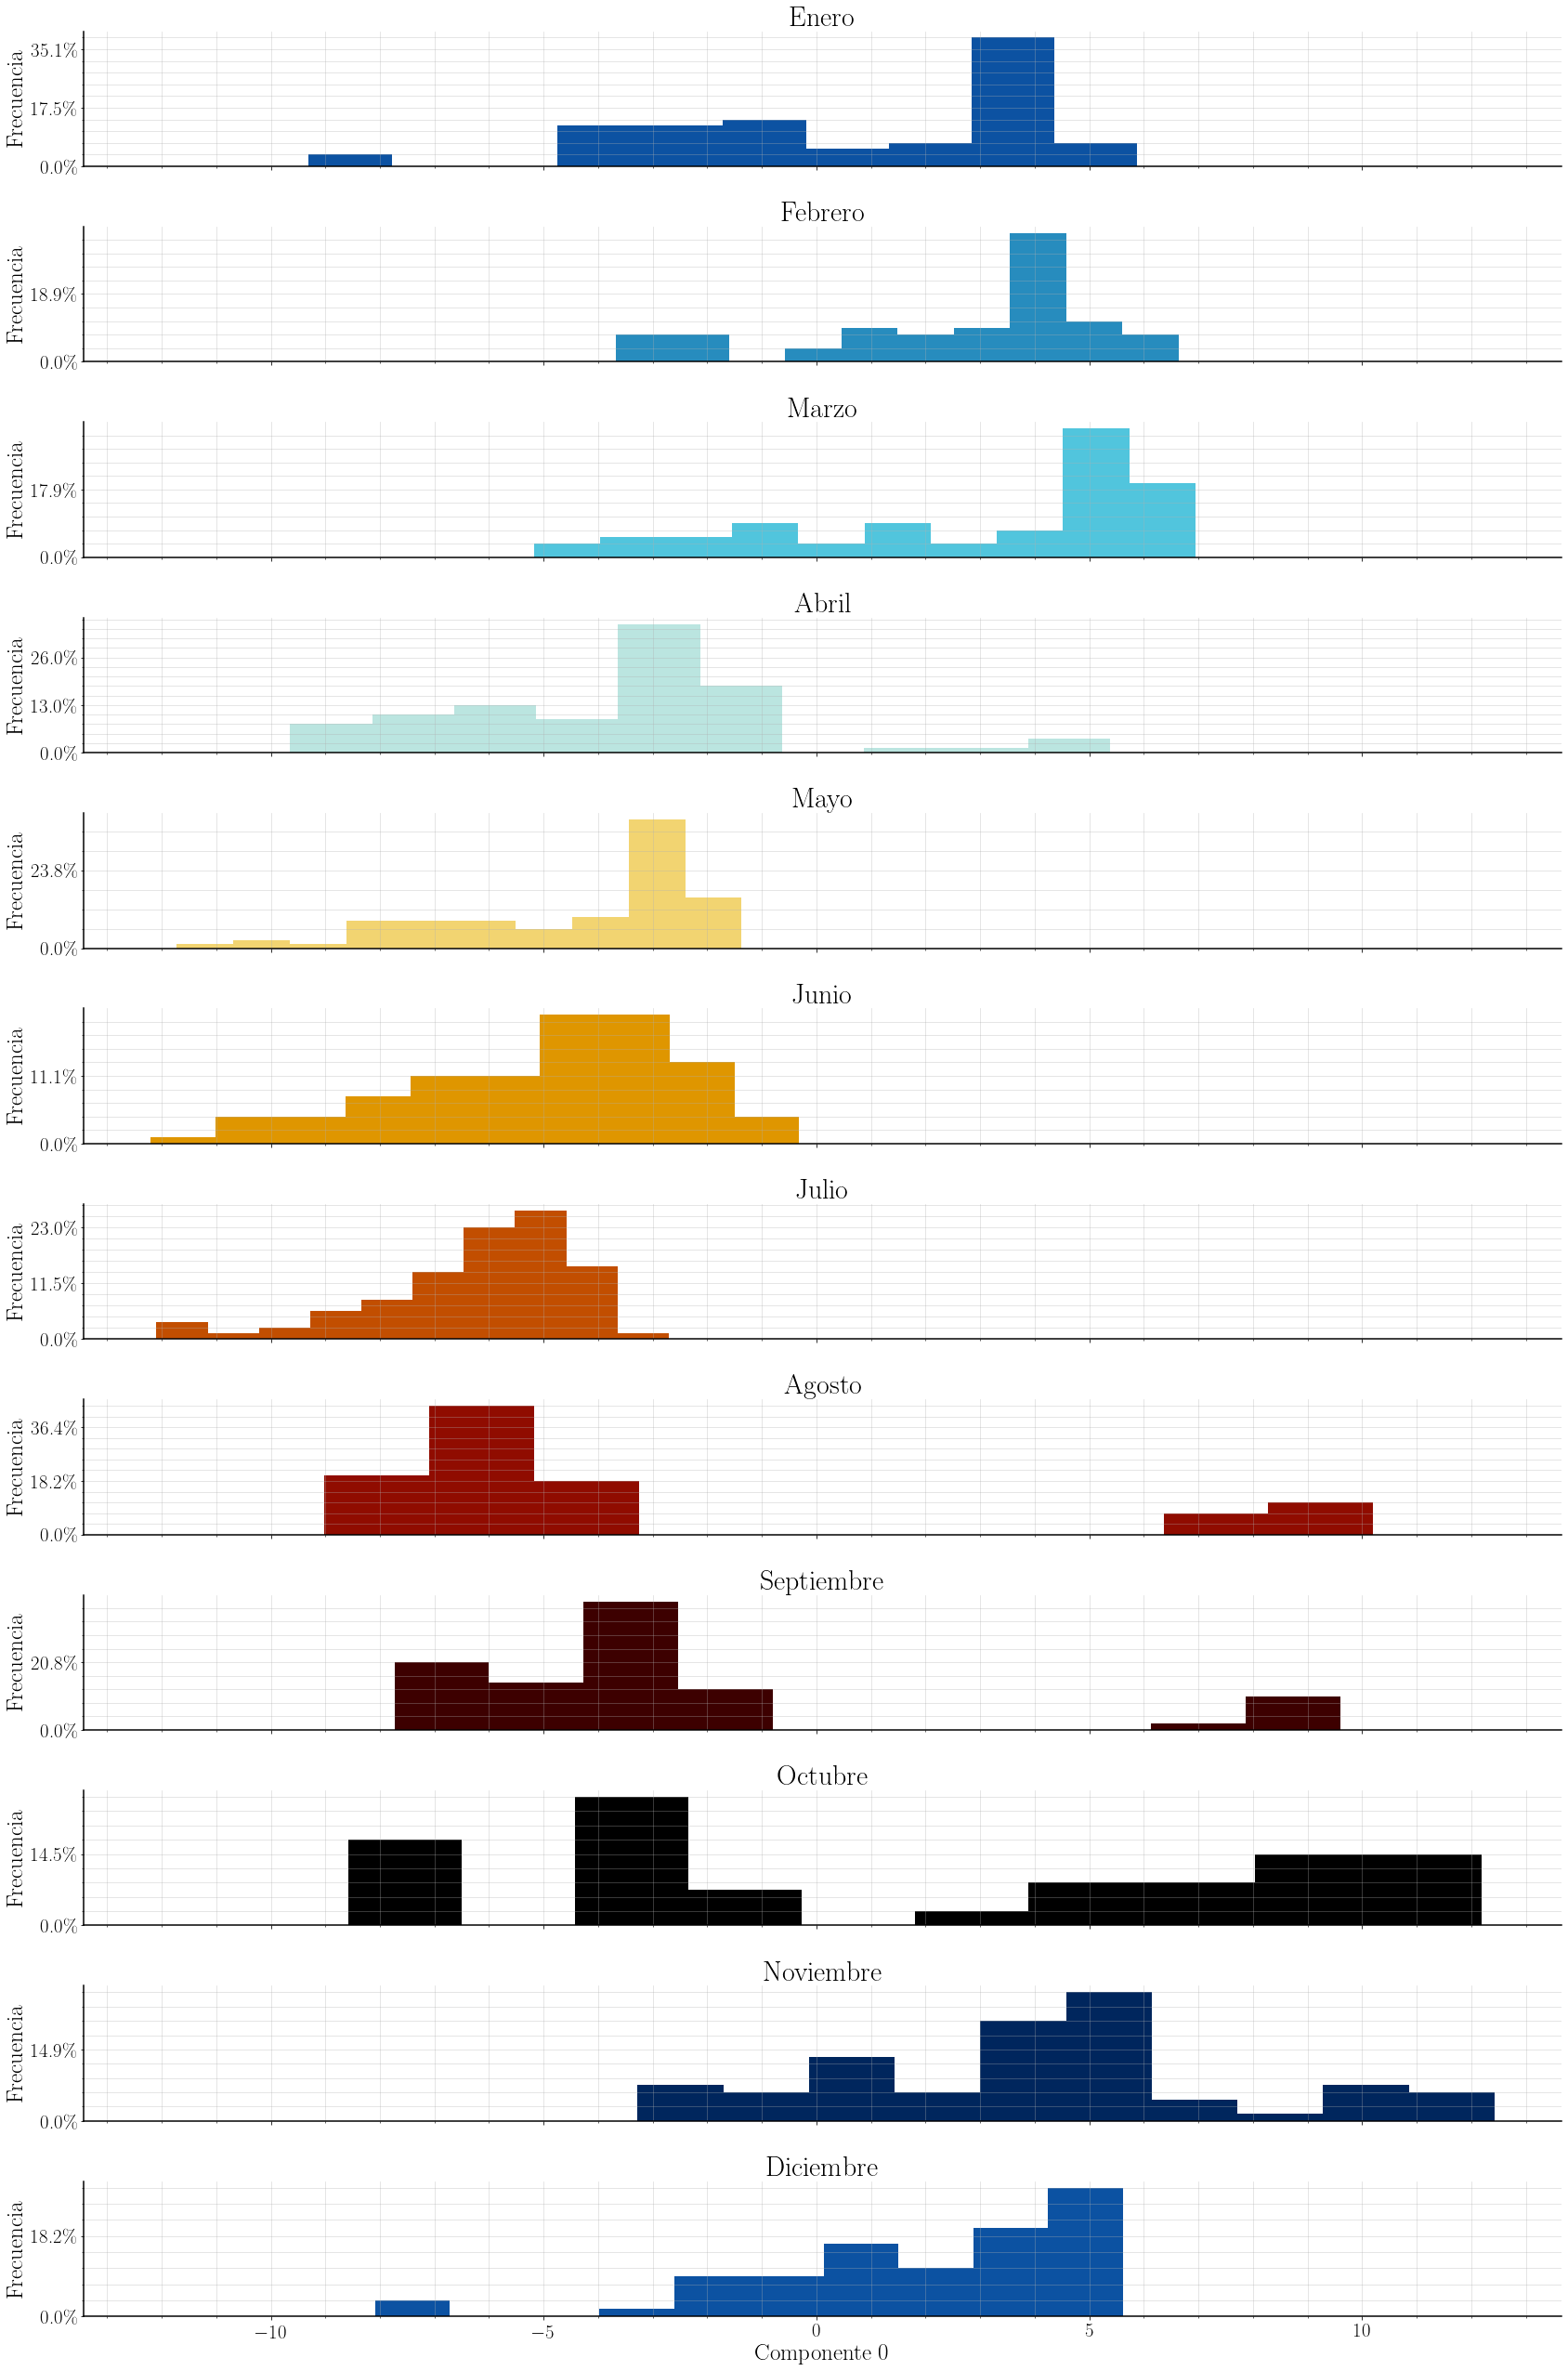

In [134]:
fig, axs = plt.subplots(12,1, squeeze = True, figsize = (24,6*6), tight_layout = True, sharex=True)

month_label = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
for month in pca_PQ.index.month.unique().sort_values().values:
    mask = pca_PQ.index.month == month
    pca_PQ.loc[mask,0].hist(ax = axs[month-1], color = colors_hist[month-1], density = False, label = month, alpha = 1.)
    axs[month-1].set_title(month_label[month-1])
    axs[month-1].set_ylabel('Frecuencia')
    axs[month-1].yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax = pca_PQ.loc[mask,0].shape[0]))

axs[-1].set_xlabel('Componente 0')

fig.savefig(fig_dir + 'pca_dist_months.pdf')

Podemos observar tanto en las figuras como en el histograma una diferenciación en el consumo de agua en días laborales y festivos. Además, encontramos distribuciones para cada mes que definen perfiles de consumo distintos. Esto nos lleva a pensar que los datos contienen estructura según la fecha en que se consuma.

## LLE <a id = "lle"></a>

Para aplicar LLE necesitamos el número de vecinos para reconstruir cada dato. Escogemos 15 vecinos (menos del $10%$ de todos los datos) para reconstruir el dato local.

In [135]:
lle = LLE(n_neighbors = 15, n_components = 3, random_state = 42)

In [137]:
lle_PQ = lle.fit_transform(PQ_fitted)

lle_PQ = pd.DataFrame(lle_PQ, index = PQ_fitted.index,
            columns = pd.Series([0, 1, 2], name = 'coords'))

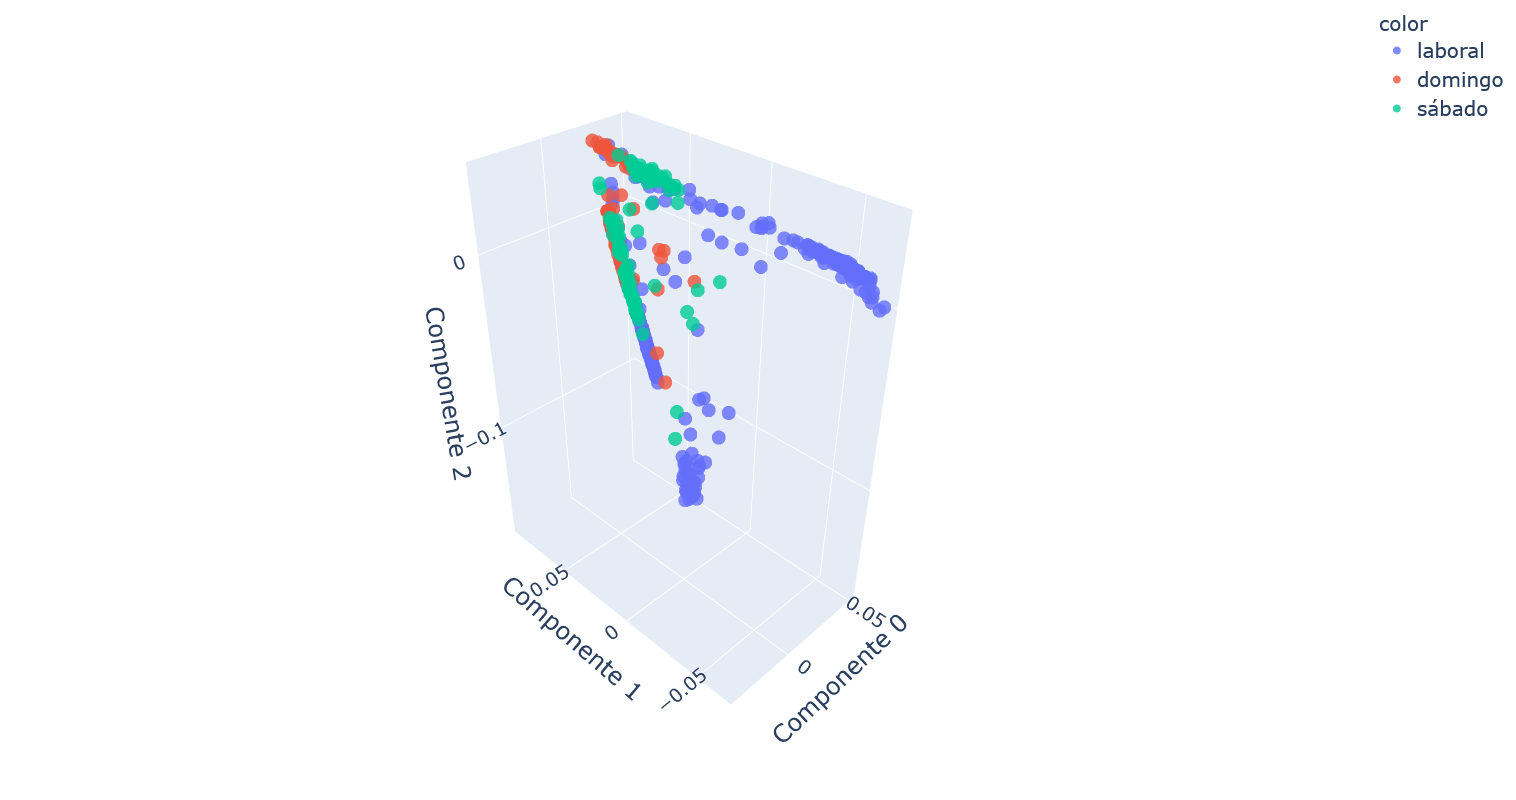

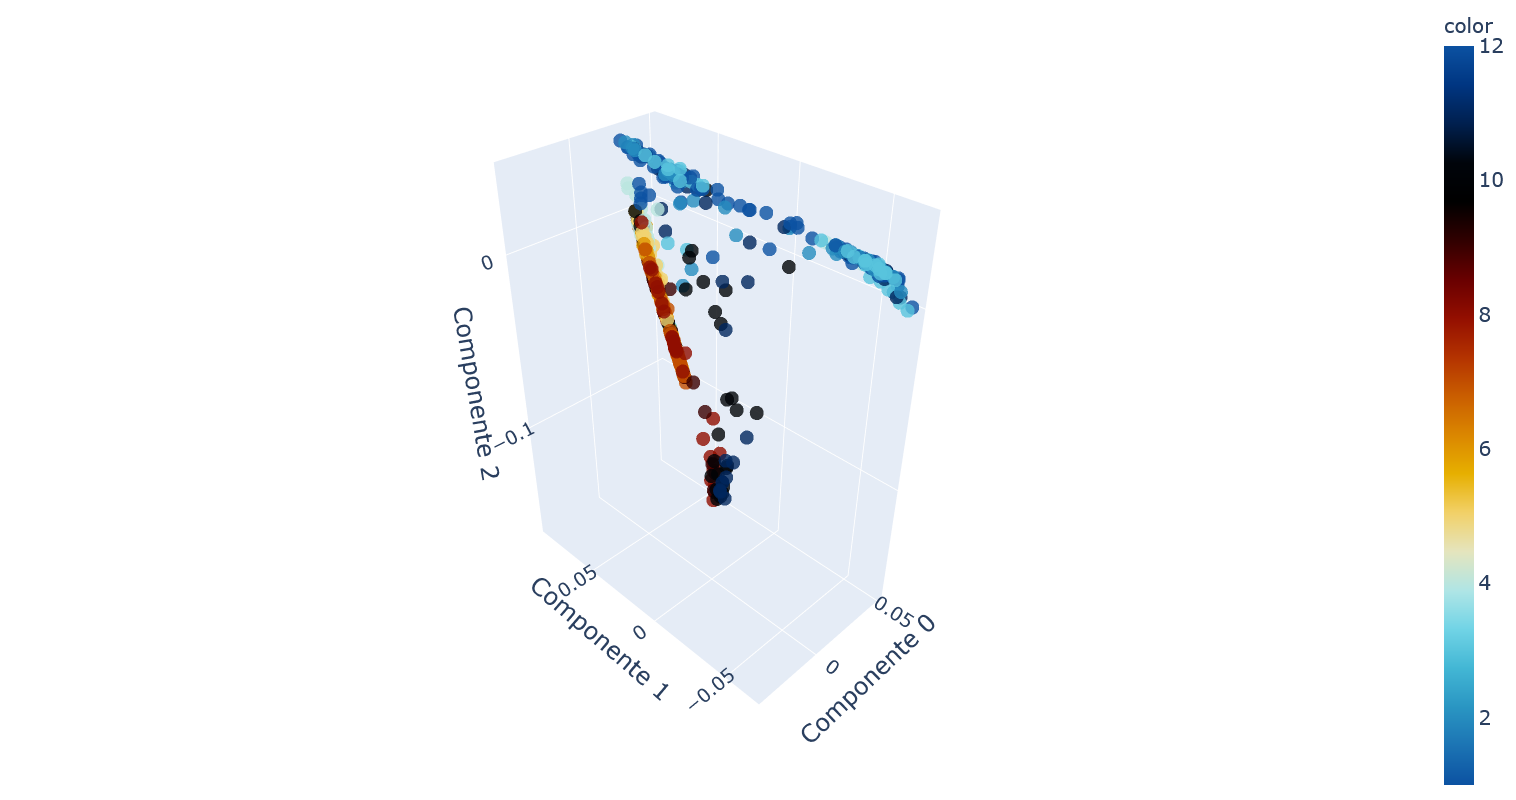

In [144]:
dayweek = give_drawing(lle_PQ, lle_PQ.index.dayofweek.to_series().transform(lambda x: ll_name[ll_repl[ll_filter == x][0]]), zoom = 1.4, x_cam = -1.25, y_cam = -1.25)
month = give_drawing(lle_PQ, lle_PQ.index.month.to_series().values, continuous_color = continuous_color_M, zoom = 1.4, x_cam = -1.25, y_cam = -1.25)


dayweek.show()
month.show()

month.write_image(fig_dir + 'lle_month.pdf')


Las estructuras que aparecen por el método de LLE observamos estructuras diferentes según los meses del año.

## Isomapas <a id = 'isomap'></a>

In [145]:
isomap = iso(n_neighbors=15, n_components=3,
             eigen_solver='auto', tol=1e-7,
             max_iter=None, path_method='auto', neighbors_algorithm='auto', n_jobs=-1,
             metric='minkowski', p=2, metric_params=None)

In [146]:
iso_PQ = isomap.fit_transform(PQ_fitted)
iso_PQ = pd.DataFrame(PQ_fitted, index = dt_D.index)

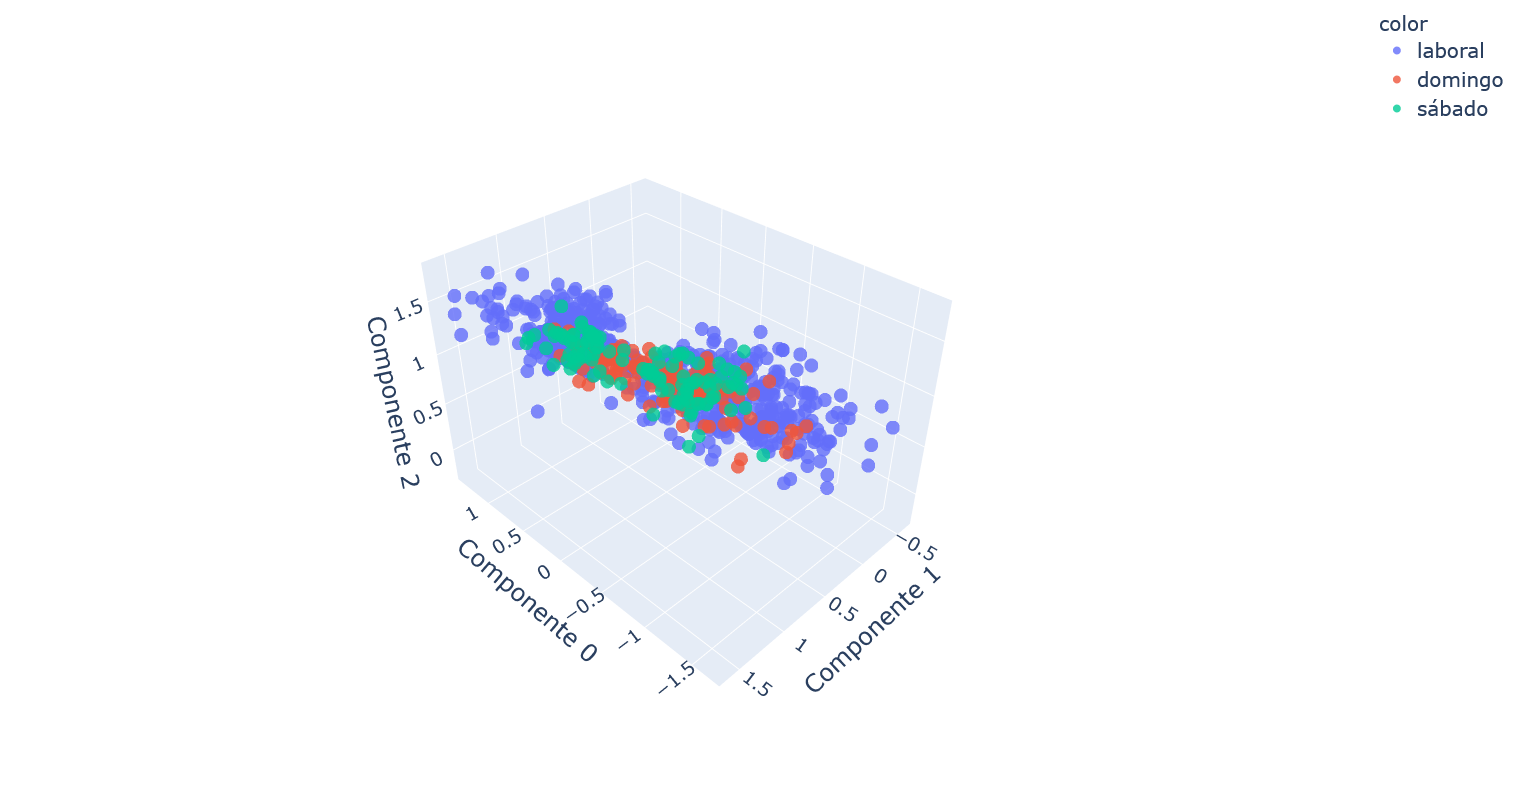

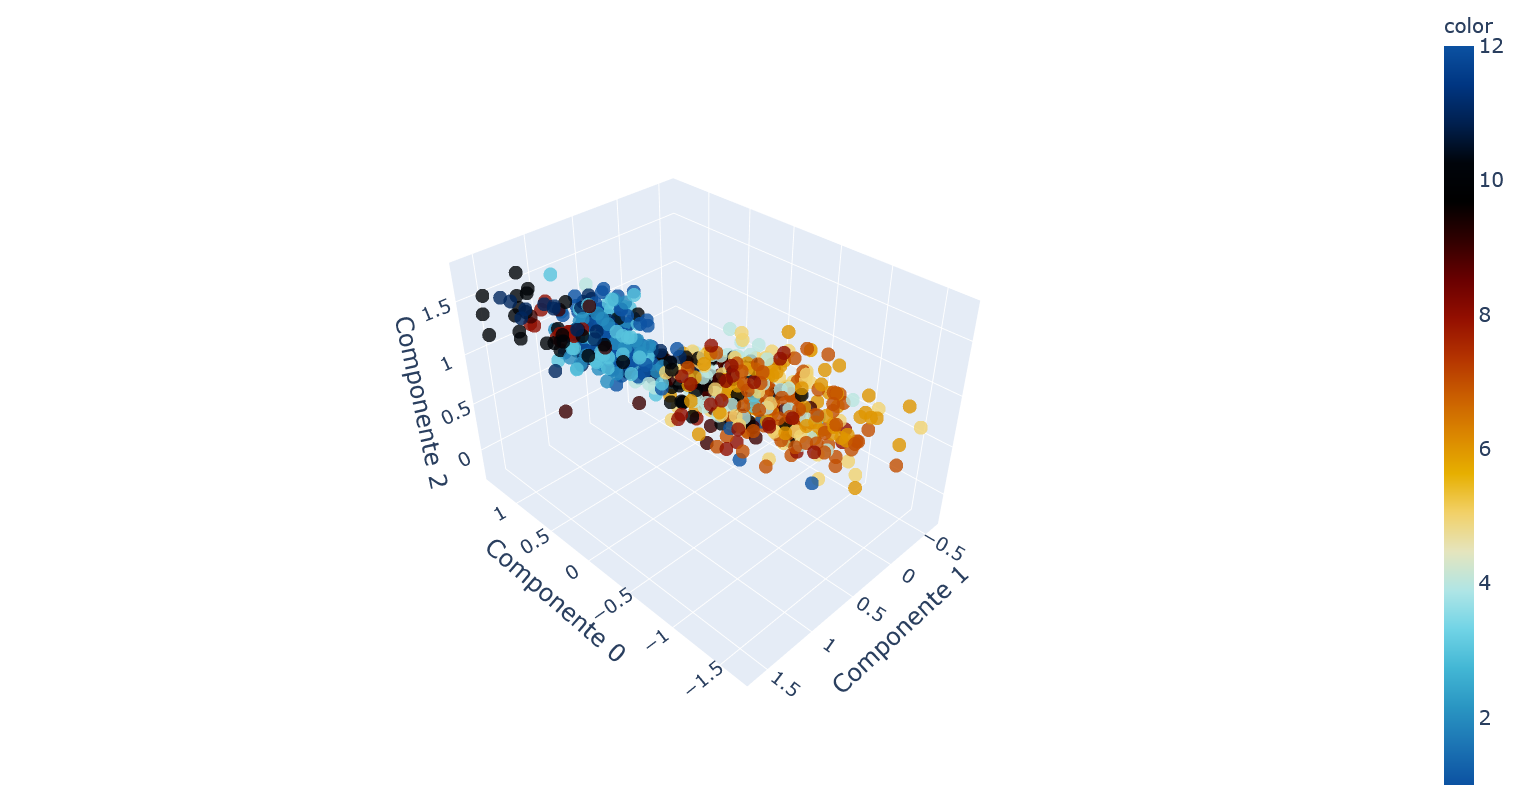

In [153]:
dayweek = give_drawing(iso_PQ, iso_PQ.index.dayofweek.to_series().transform(lambda x: ll_name[ll_repl[ll_filter == x][0]]), zoom = 1.4, x_cam = -1.25)
month = give_drawing(iso_PQ, iso_PQ.index.month.to_series().values, continuous_color = continuous_color_M, zoom = 1.4, x_cam = -1.25)

month.write_image(fig_dir + 'iso_month.pdf')

dayweek.show()
month.show()

## t-SNE <a id = "tsne"></a>

In [177]:
tsne = TSNE(learning_rate = 100.0, perplexity = 10.0, n_components = 3, metric = "precomputed", random_state = 42, n_jobs = -1)

### Presión <a id = "tsne_presion"></a>

Comenzamos por estudiar las variables por separado, comenzando con la presión.

In [178]:
tsne_P = tsne.fit_transform(dd_P_eucl)

tsne_P = pd.DataFrame(tsne_P, index = PQ_fitted.index,
             columns = pd.Index([0, 1, 2], name = 'coord'))

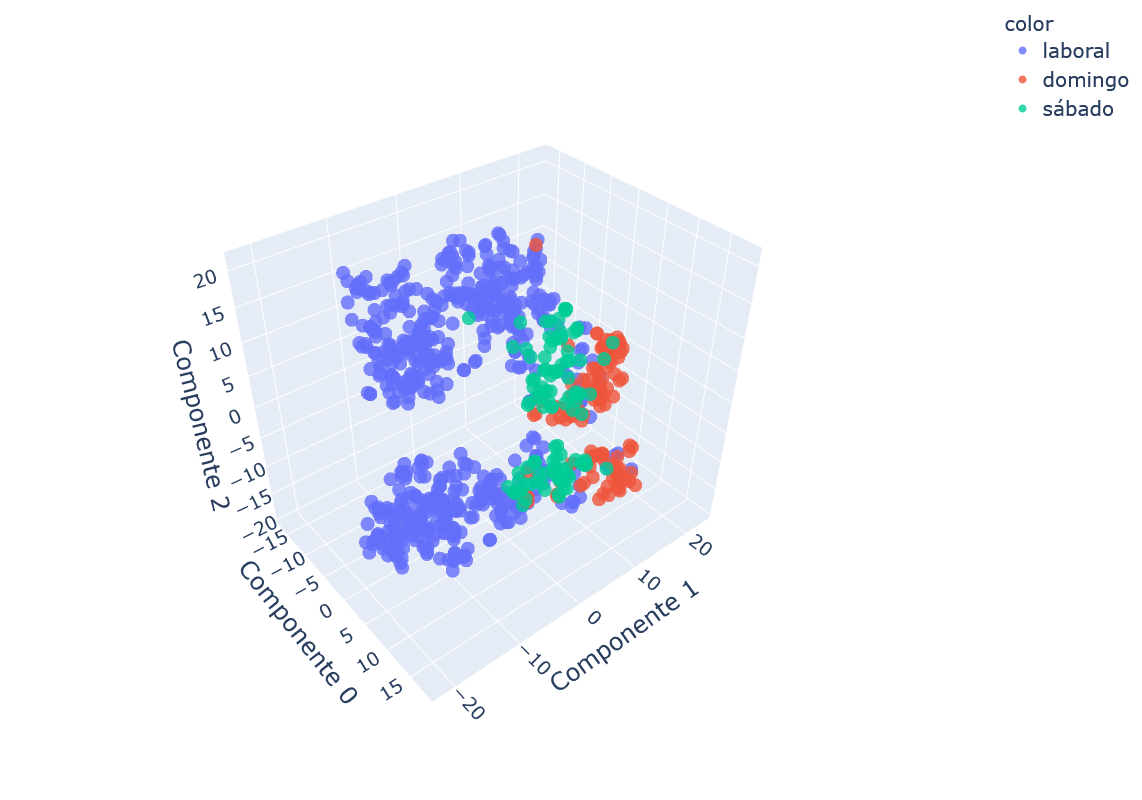

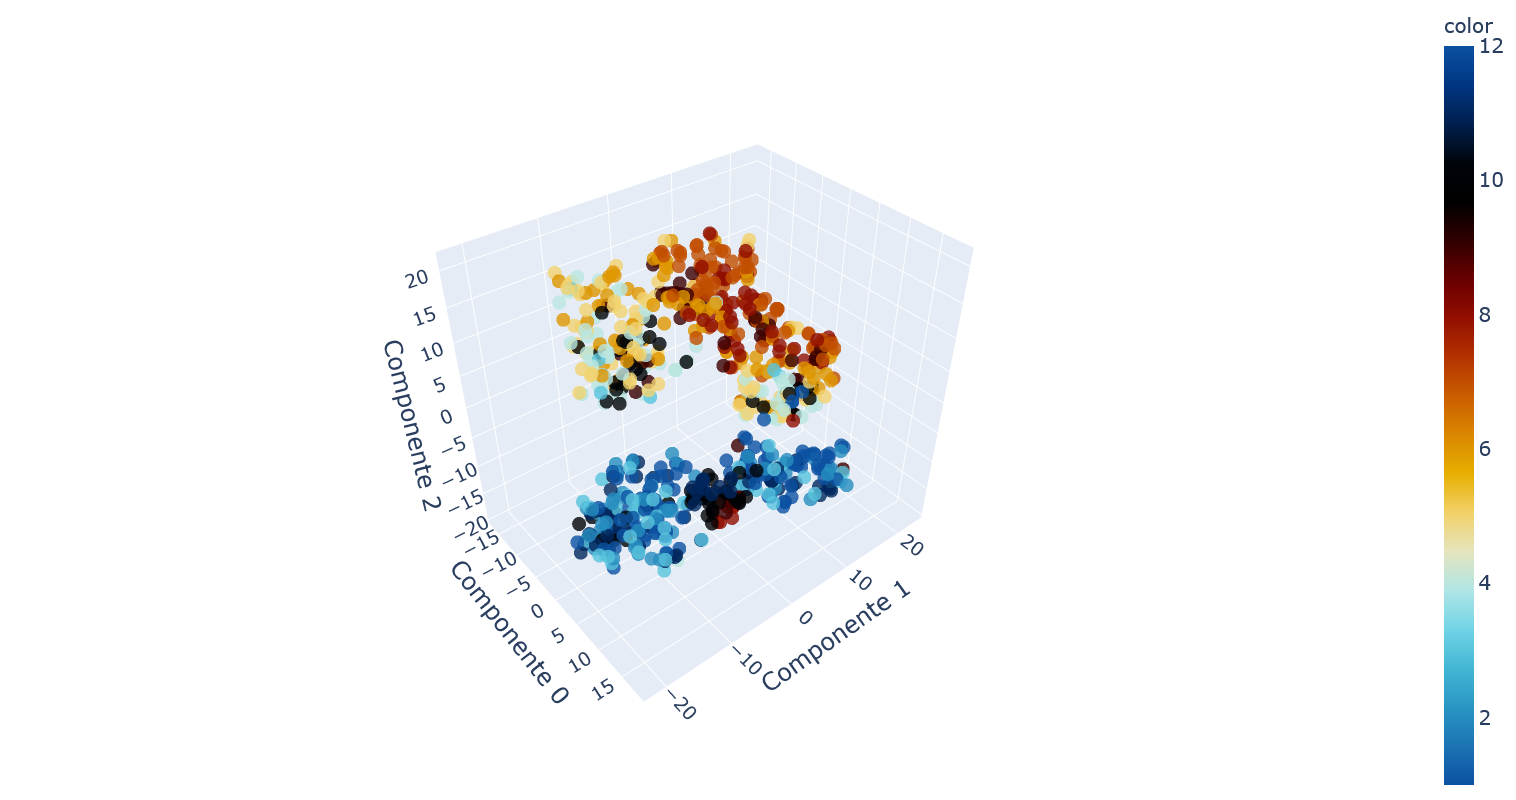

In [181]:
dayweek = give_drawing(tsne_P, tsne_P.index.dayofweek.to_series().transform(lambda x: ll_name[ll_repl[ll_filter == x][0]]), y_cam = -1, zoom = 1.4)
month = give_drawing(tsne_P, tsne_P.index.month.to_series().values, continuous_color = continuous_color_M, y_cam = -1, zoom = 1.4)

month.write_image(fig_dir + 'tsne_P_month.pdf')

dayweek.show()
month.show()

Observamos estructuras que se corresponden por días de la semana y mes del año.

### Caudal <a id = "tsne_caudal"></a>

Creamos un modelo distinto para la variable del caudal.

In [186]:
tsne = TSNE(learning_rate = 100.0, perplexity = 20.0, n_components = 3, random_state = 42, n_jobs = -1)

In [187]:
tsne_Q = tsne.fit_transform(dd_Q_eucl)

tsne_Q = pd.DataFrame(tsne_Q, index = PQ_fitted.index,
             columns = pd.Index([0, 1, 2], name = 'coord'))

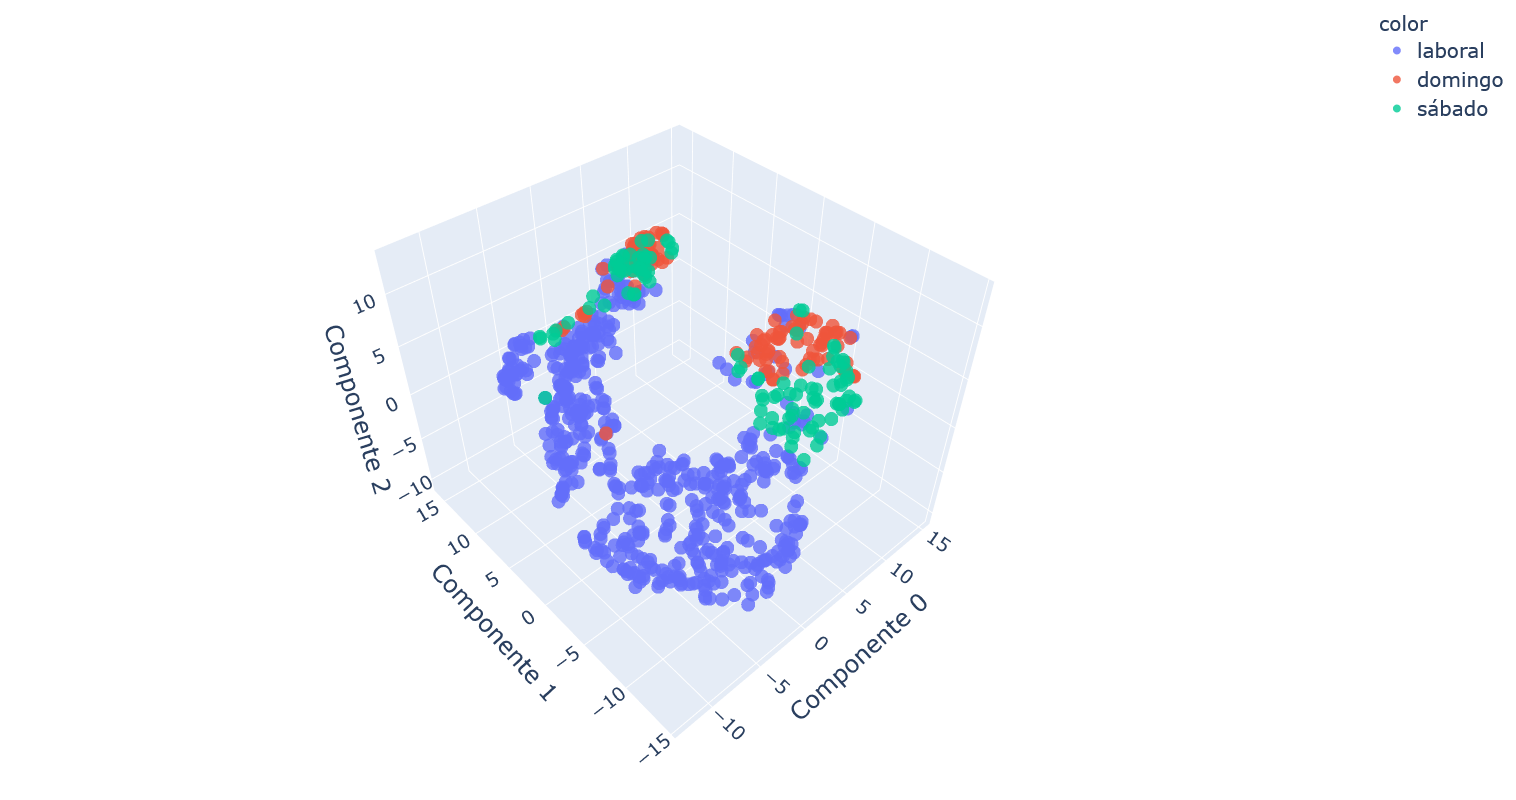

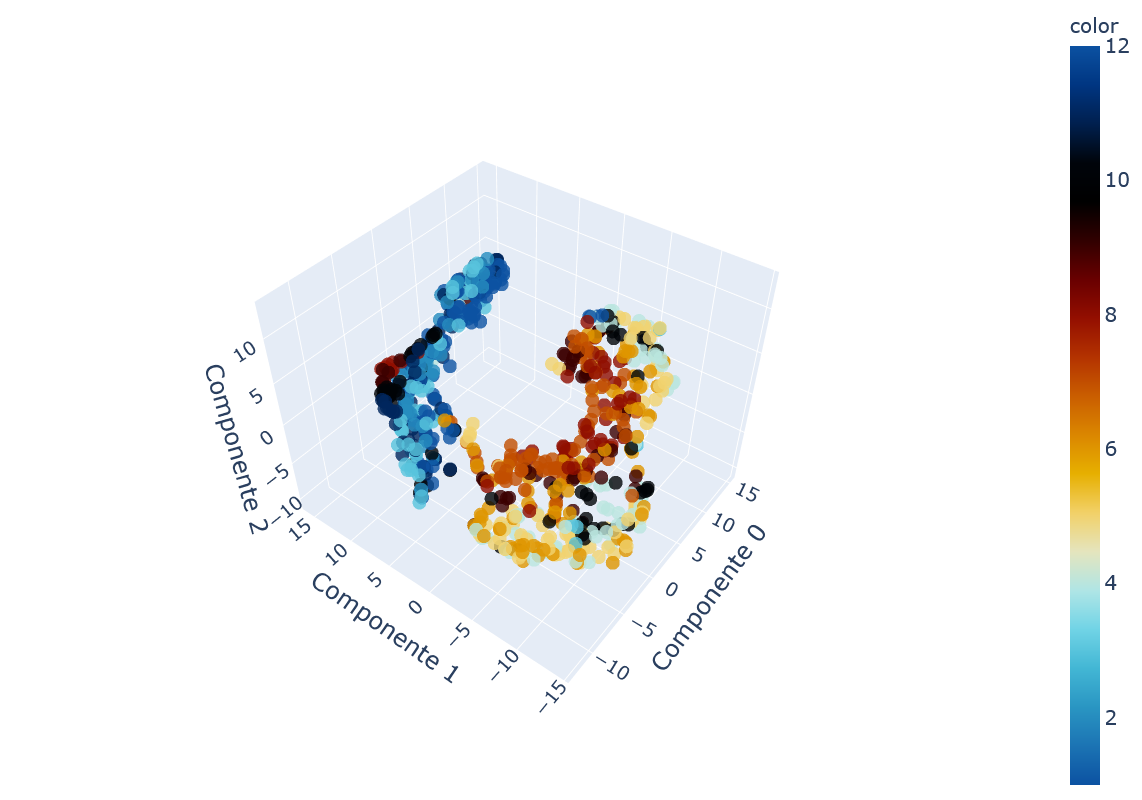

In [189]:
dayweek = give_drawing(tsne_Q, tsne_Q.index.dayofweek.to_series().transform(lambda x: ll_name[ll_repl[ll_filter == x][0]]), x_cam = -1.25, y_cam = -1.25, zoom = 1.4)
month = give_drawing(tsne_Q, tsne_Q.index.month.to_series().values, continuous_color = continuous_color_M, x_cam = -1.25, y_cam = -1.25, zoom = 1.4)

month.write_image(fig_dir + 'tsne_Q_month.pdf')

dayweek.show()
month.show()

### Ambas variables <a id = "tsne_ambas"></a>

In [190]:
tsne = TSNE(learning_rate = 100.0, perplexity = 20.0, n_components = 3, random_state = 42, n_jobs = -1)

In [191]:
tsne_PQ = tsne.fit_transform(dd_eucl)

tsne_PQ = pd.DataFrame(tsne_PQ, index = PQ_fitted.index,
             columns = pd.Index([0, 1, 2], name = 'coord'))

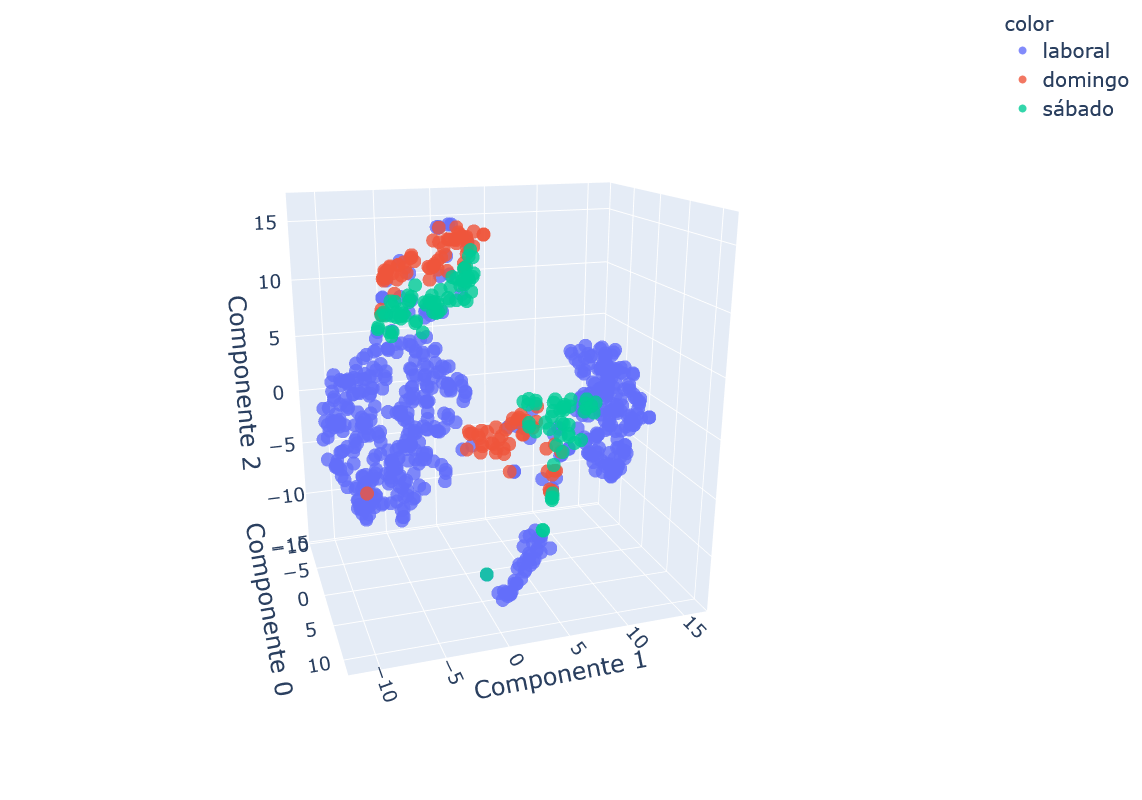

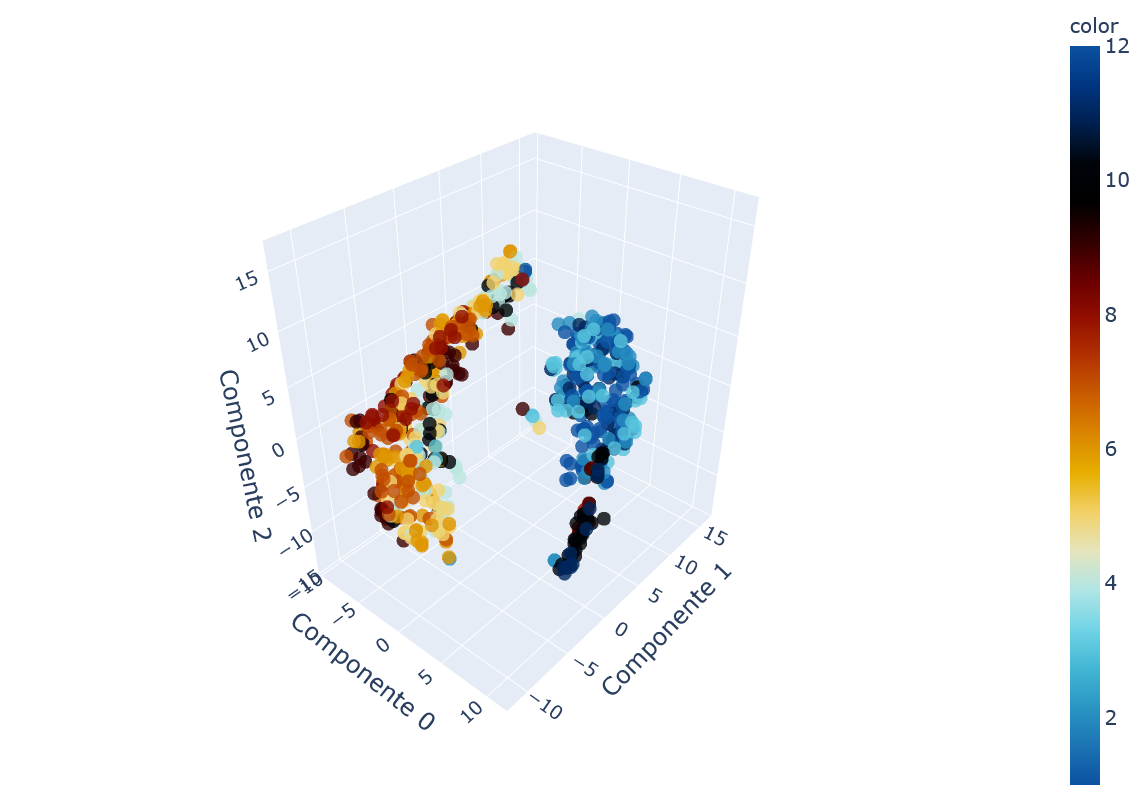

In [193]:
dayweek = give_drawing(tsne_PQ, tsne_PQ.index.dayofweek.to_series().transform(lambda x: ll_name[ll_repl[ll_filter == x][0]]), y_cam = -1.25, z_cam = 1, zoom = 1.4)
month = give_drawing(tsne_PQ, tsne_PQ.index.month.to_series().values, continuous_color = continuous_color_M, y_cam = -1.25, z_cam = 1, zoom = 1.4)

month.write_image(fig_dir + 'tsne_PQ_month.pdf')

dayweek.show()
month.show()

# Detección de anomalías

In [54]:
anomaly_s = pd.DataFrame(columns = ['BDSCAN', 'OPTICS', 'LOF'], index = ['eucl', 'dtw', 'gak'])
anomaly_c = pd.DataFrame(columns = ['BDSCAN', 'OPTICS', 'LOF'], index = ['eucl', 'dtw', 'gak'])

In [55]:
sil_factor = 0.7
cal_factor = 0.3

In [56]:
dd_gak = np.abs(dd_gak)
dd_P_gak = np.abs(dd_P_gak)
dd_Q_gak = np.abs(dd_Q_gak)

## BDSCAN <a id = 'bdscan'></a>

In [33]:
dbscan = DBSCAN(eps = 1.8, min_samples = 30, metric = "precomputed")

In [34]:
dbscan.fit(dd_eucl)
class_eucl = dbscan.labels_

dbscan.fit(dd_dtw)
class_dtw = dbscan.labels_

dbscan.fit(dd_gak)
class_gak = dbscan.labels_

In [36]:
anomaly_s['BDSCAN'] = [mm.silhouette_score(dd_eucl, labels = class_eucl),
                       mm.silhouette_score(dd_dtw, labels = class_dtw),
                       mm.silhouette_score(dd_gak, labels = class_gak)]

anomaly_c['BDSCAN'] = [mm.calinski_harabasz_score(PQ_fitted, labels = class_eucl),
                       mm.calinski_harabasz_score(PQ_fitted, labels = class_dtw),
                       mm.calinski_harabasz_score(PQ_fitted, labels = class_gak)]

## OPTICS <a id = "optics"></id>

In [57]:
clust = OPTICS(min_samples=50, xi=0.05, min_cluster_size=.1, metric = "precomputed")
qq = 1 - np.linspace(0.0,0.2,100)

In [58]:
clust.fit(dd_dtw)
classes_dtw = np.array([clust.reachability_ < q for q in np.quantile(a = clust.reachability_[~np.isinf(clust.reachability_)], q = qq)])

clust.fit(dd_eucl)
classes_eucl = np.array([clust.reachability_ < q for q in np.quantile(a = clust.reachability_[~np.isinf(clust.reachability_)], q = qq)])

clust.fit(dd_gak)
classes_gak = np.array([clust.reachability_ < q for q in np.quantile(a = clust.reachability_[~np.isinf(clust.reachability_)], q = qq)])

In [59]:
score_eucl_sil = [mm.silhouette_score(dd_eucl, labels = class_eucl) for class_eucl in classes_eucl]
score_dtw_sil = [mm.silhouette_score(dd_dtw, labels = class_dtw) for class_dtw in classes_dtw]
score_gak_sil = [mm.silhouette_score(dd_gak, labels = class_gak) for class_gak in classes_gak]

score_eucl_cal = [mm.calinski_harabasz_score(PQ_fitted, labels = class_eucl) for class_eucl in classes_eucl]
score_dtw_cal = [mm.calinski_harabasz_score(PQ_fitted, labels = class_dtw) for class_dtw in classes_dtw]
score_gak_cal = [mm.calinski_harabasz_score(PQ_fitted, labels = class_gak) for class_gak in classes_gak]

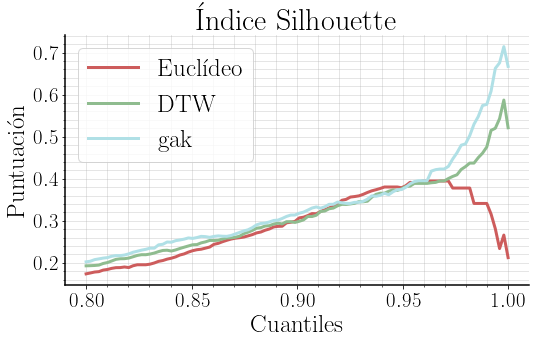

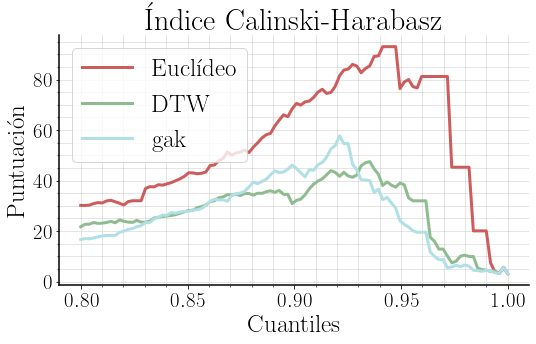

In [60]:
fig_s, ax_s = plt.subplots()
ax_s.plot(qq, score_eucl_sil, label = 'Euclídeo')
ax_s.plot(qq, score_dtw_sil, label = 'DTW')
ax_s.plot(qq, score_gak_sil, label = 'gak')
ax_s.set_xlabel('Cuantiles')
ax_s.set_ylabel('Puntuación')
ax_s.set_title("Índice Silhouette")
ax_s.legend()

fig_c, ax_c = plt.subplots()
ax_c.plot(qq, score_eucl_cal, label = 'Euclídeo')
ax_c.plot(qq, score_dtw_cal, label = 'DTW')
ax_c.plot(qq, score_gak_cal, label = 'gak')
ax_c.set_xlabel('Cuantiles')
ax_c.set_ylabel('Puntuación')
ax_c.set_title("Índice Calinski-Harabasz")
ax_c.legend()

fig_s.savefig(fig_dir + 'optics_sil.pdf')
fig_c.savefig(fig_dir + 'optics_cal.pdf')

In [59]:
score_eucl = scaler.fit_transform([score_eucl_sil, score_eucl_cal]).reshape(2,-1)
index_eucl = np.where((score_eucl[0] * sil_factor + score_eucl[1] * cal_factor) == (score_eucl[0] * sil_factor + score_eucl[1] * cal_factor).max())[0][-1]

score_dtw = scaler.fit_transform([score_dtw_sil, score_dtw_cal]).reshape(2,-1)
index_dtw = np.where((score_dtw[0] * sil_factor + score_dtw[1] * cal_factor) == (score_dtw[0] * sil_factor + score_dtw[1] * cal_factor).max())[0][-1]

score_gak = scaler.fit_transform([score_gak_sil, score_gak_cal]).reshape(2,-1)
index_gak = np.where((score_gak[0] * sil_factor + score_gak[1] * cal_factor) == (score_gak[0] * sil_factor + score_gak[1] * cal_factor).max())[0][-1]

In [60]:
anomaly_s['OPTICS'] = [score_eucl_sil[index_eucl],
                       score_dtw_sil[index_dtw],
                       score_gak_sil[index_gak]]

anomaly_c['OPTICS'] = [score_eucl_cal[index_eucl],
                       score_dtw_cal[index_dtw],
                       score_gak_cal[index_gak]]

In [61]:
optics_params = pd.DataFrame(columns = ['Cuartil'], index = ['eucl', 'dtw', 'gak'])

optics_params.iloc[:,0] = [qq[index_eucl],
                           qq[index_dtw],
                           qq[index_gak]
                           ]

optics_params

Cuartil
eucl  0.941414
dtw   0.997980
gak   0.997980

## LOF <a id = "lof"></a>

In [62]:
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1, metric = "precomputed")

In [63]:
def LOF(dd, nn, contamination, data = None):
    params = np.meshgrid(nn, contamination, indexing = "ij")
    it = np.nditer(params, flags = ['multi_index'])
    
    silhouette = np.zeros(params[0].shape)
    calinski = np.zeros(params[0].shape)
    for x in it:
        clf = LocalOutlierFactor(n_neighbors=x[0].item(), contamination=x[1].item(), metric = "precomputed")
        classes = clf.fit_predict(dd)
        silhouette[it.multi_index] = mm.silhouette_score(dd, labels = classes)
        calinski[it.multi_index] = mm.calinski_harabasz_score(data, labels = classes)
    return silhouette, calinski, params[0], params[1]

In [64]:
nn = np.linspace(5,100,10, dtype = int)
contamination = np.logspace(np.log10(0.01),np.log10(0.5),10)

sil_eucl, cal_eucl,_,_ = LOF(dd_eucl, nn, contamination, data = PQ_fitted)
sil_dtw, cal_dtw,_,_ = LOF(dd_dtw, nn, contamination, data = PQ_fitted)
sil_gak, cal_gak,_,_ = LOF(dd_gak, nn, contamination, data = PQ_fitted)

Calculemos los valores de los scores combinándolos:

In [65]:
sil_eucl_normal = scaler.fit_transform(sil_eucl.reshape(1,100)).reshape(10,10)
cal_eucl_normal = scaler.fit_transform(cal_eucl.reshape(1,100)).reshape(10,10)
score_eucl = sil_eucl_normal * sil_factor + cal_eucl_normal * cal_factor
eucl_index = np.where(score_eucl == np.max(score_eucl))

sil_dtw_normal = scaler.fit_transform(sil_dtw.reshape(1,100)).reshape(10,10)
cal_dtw_normal = scaler.fit_transform(cal_dtw.reshape(1,100)).reshape(10,10)
score_dtw = sil_dtw_normal * sil_factor + cal_dtw_normal * cal_factor
dtw_index = np.where(score_dtw == np.max(score_dtw))

sil_gak_normal = scaler.fit_transform(sil_gak.reshape(1,100)).reshape(10,10)
cal_gak_normal = scaler.fit_transform(cal_gak.reshape(1,100)).reshape(10,10)
score_gak = sil_gak_normal * sil_factor + cal_gak_normal * cal_factor
gak_index = np.where(score_gak == np.max(score_gak))

In [66]:
anomaly_s['LOF'] = [sil_eucl[eucl_index][0],
                    sil_dtw[dtw_index][0],
                    sil_gak[gak_index][0],
                    ]
anomaly_c['LOF'] = [cal_eucl[eucl_index][0],
                    cal_dtw[dtw_index][0],
                    cal_gak[gak_index][0]
                    ]

Guardemos los parámetros óptimos para cada métrica en una tabla:

In [67]:
params_lof = pd.DataFrame(columns = ['nn', 'contaminacion'], index = ['eucl', 'dtw', 'gak'])

In [68]:
params_lof.iloc[:, 0] = [nn[eucl_index[0]][0], nn[dtw_index[0]][0], nn[gak_index[0]][0]]
params_lof.iloc[:, 1] = [contamination[eucl_index[1]][0], contamination[dtw_index[1]][0], contamination[gak_index[1]][0]]

In [69]:
params_lof

nn  contaminacion
eucl  89       0.056898
dtw   89       0.087876
gak   78       0.087876

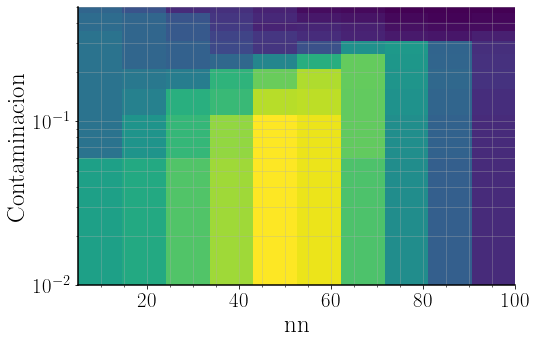

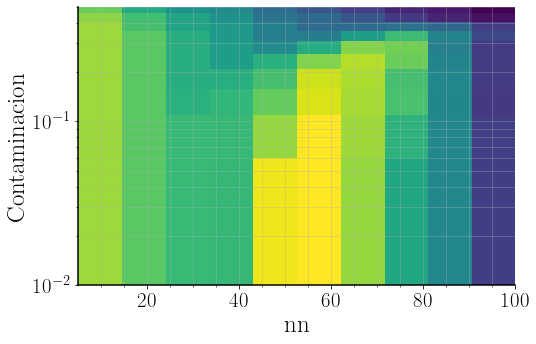

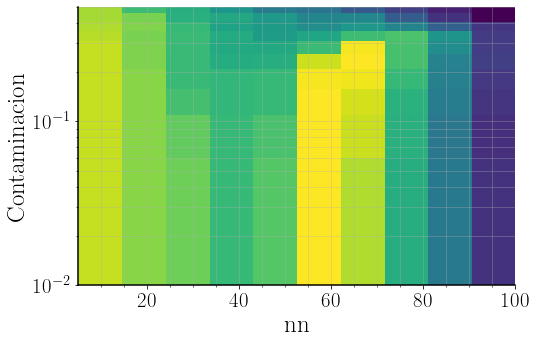

In [70]:
extent = [5,100,0.01,0.5]

fig_eucl, ax_eucl = plt.subplots()
ax_eucl.imshow(score_eucl, extent = extent, aspect = 'auto')
ax_eucl.set_yscale('log')
ax_eucl.set_ylabel('Contaminacion')
ax_eucl.set_xlabel('nn')

fig_dtw, ax_dtw = plt.subplots()
ax_dtw.imshow(score_dtw, extent = extent, aspect = 'auto')
ax_dtw.set_yscale('log')
ax_dtw.set_ylabel('Contaminacion')
ax_dtw.set_xlabel('nn')

fig_gak, ax_gak = plt.subplots()
ax_gak.imshow(score_gak, extent = extent, aspect = 'auto')
ax_gak.set_yscale('log')
ax_gak.set_ylabel('Contaminacion')
ax_gak.set_xlabel('nn')

fig_eucl.savefig(fig_dir + 'lof_eucl.pdf')
fig_dtw.savefig(fig_dir + 'lof_dtw.pdf')
fig_gak.savefig(fig_dir + 'lof_gak.pdf')

La tabla final de puntuaciones es:

* Silhouette Score

In [71]:
anomaly_s

BDSCAN    OPTICS       LOF
eucl  0.359353  0.380362  0.358328
dtw   0.382560  0.587186  0.336281
gak   0.313282  0.714190  0.346797

* Calinski Score

In [72]:
anomaly_c

BDSCAN     OPTICS        LOF
eucl  79.656956  92.998782  57.479613
dtw   22.433668   5.665587  33.514707
gak   46.905185   5.665587  34.936739

# Clustering de las series

In [73]:
clust_s = pd.DataFrame(columns = ['markov', 'kmeans', 'birch'], index = ['eucl', 'dtw', 'gak'])
clust_c = pd.DataFrame(columns = ['markov', 'kmeans', 'birch'], index = ['eucl', 'dtw', 'gak'])

## Modelos ocultos de Markov <a id = "markov"></a>

A continuación definimos 3 funciones para aplicar modelos de Markov. El primero consiste en encontrar los estados ocultos de markov del modelo, el segundo une los datos con los estados medios de Markov para aplicar t-SNE. El último dibuja el resultado.

In [80]:
def find_hs(data, n_components = 3, covariance_type = 'tied'):
    markov = hmm.GaussianHMM(n_components = n_components, covariance_type = covariance_type, verbose = False, random_state = 42)
    data_new = markov.fit(data)
    return markov, markov.decode(data)[1]

def tsne_base(data, index, markov, learning_rate = 100.0, perplexity = 10.0, n_components = 3):
    tsne = TSNE(learning_rate = learning_rate, perplexity = perplexity, n_components = n_components, random_state = 42, n_jobs = -1)
    
    # Unimos los datos junto con los estados ocultos como si de datos se tratara
    data_orig = np.append(data, markov.means_, axis = 0)
    data_tsne = tsne.fit_transform(data_orig)
    
    # Volvemos a separar los datos en data frames
    data_var = data_tsne[:data.shape[0],:]
    hs = data_tsne[data.shape[0]:, :]

    return pd.DataFrame(data_var, index = index), pd.DataFrame(hs)

def draw(data_var, hs, color_vector, names, tick_size = 15):
    graph = px.scatter_3d(data_var, x = 0, y= 1, z = 2,
                   color = color_vector,
                   opacity = 0.8,
                   width = 800, height = 800,
                   color_continuous_scale = 'rainbow'
                   )

    hs_graph = go.Scatter3d(x = hs[0], y = hs[1], z = hs[2],
            mode = "markers",
            marker = dict(
                color = "black",
                opacity = 0.8
            ))

    zoom = 1.4
    camera = dict(
        up=dict(x=0, y=0, z=1),
        center=dict(x=0, y=0, z=0),
        eye=dict(x=1.25*zoom, y=1.25*zoom, z=1.25*zoom)
    )
    
    graph.layout['scene'].xaxis.title.text = names[0]
    graph.layout['scene'].yaxis.title.text = names[1]
    graph.layout['scene'].zaxis.title.text = names[2]
    
    graph.layout['scene'].xaxis.tickfont.size = tick_size
    graph.layout['scene'].yaxis.tickfont.size = tick_size
    graph.layout['scene'].zaxis.tickfont.size = tick_size
    
    graph.add_traces(hs_graph)
    graph.update_layout(font_size = 20, scene_camera = camera, **plotly_params)
    return graph

In [75]:
markov, classes = find_hs(PQ_fitted, 6, covariance_type = 'full')

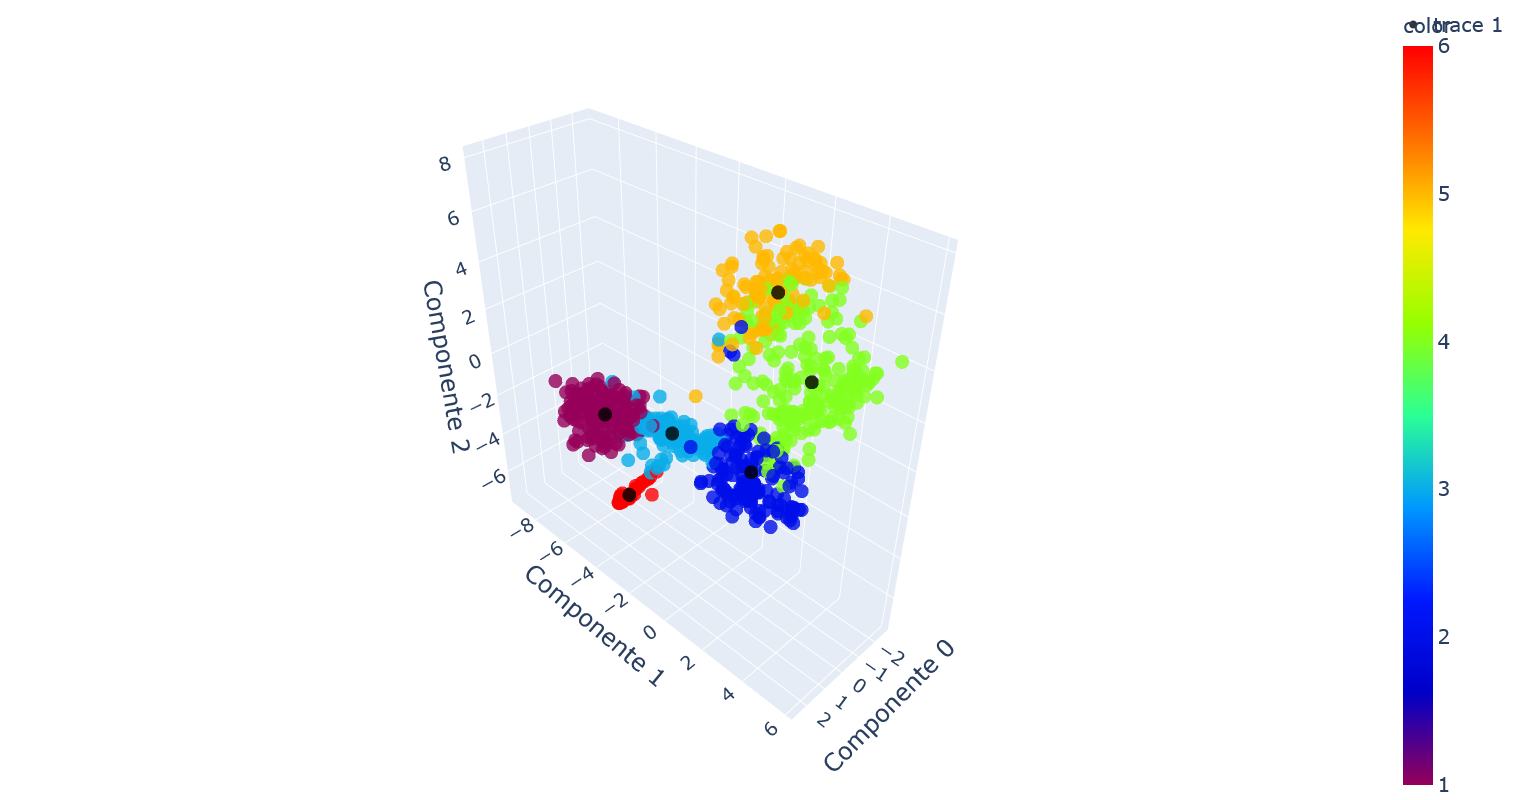

In [81]:
PQ, hs = tsne_base(PQ_fitted, PQ_fitted.index, markov, perplexity = 120.0)
PQ = pd.concat([PQ, pd.Series(classes, index = PQ_fitted.index, name = 'class')], axis = 1)

graph = draw(PQ, hs, PQ['class']+1, ['Componente 0', 'Componente 1', 'Componente 2'], tick_size = 15)
graph.write_image(fig_dir + 'markov_tsne.pdf')
graph.show()

In [82]:
clust_s['markov'] = [mm.silhouette_score(dd_eucl, labels = classes),
                     mm.silhouette_score(dd_dtw, labels = classes),
                     mm.silhouette_score(dd_gak, labels = classes)]

clust_c['markov'] = [mm.calinski_harabasz_score(PQ_fitted, labels = classes),
                     mm.calinski_harabasz_score(PQ_fitted, labels = classes),
                     mm.calinski_harabasz_score(PQ_fitted, labels = classes)]

## K-means <a id = "kmeans"></a>

Intentamos agrupar los datos en clusters utilizando la métrica euclídea y DTW.

In [83]:
neighbours = np.arange(3,10,2)
metrics = [('euclidean', dd_eucl), ('dtw', dd_dtw)]

M_s = np.empty((len(metrics), len(neighbours)))
M_c = np.empty((len(metrics), len(neighbours)))
M_s.fill(np.nan)
M_c.fill(np.nan)

for i, n in enumerate(neighbours):
    for j, metric in enumerate(metrics):
        kk = kmeans(n, metric = metric[0],
               n_jobs = -1, random_state = 42, verbose = 0)
        kk.fit(PQ_fitted)
        M_s[j,i] = mm.silhouette_score(PQ_fitted, labels = kk.labels_)
        M_c[j,i] = mm.calinski_harabasz_score(metric[1], labels = kk.labels_)

In [84]:
score_eucl = scaler.fit_transform([M_s[0]]).reshape(-1) * sil_factor + scaler.fit_transform([M_c[0]]).reshape(-1) * cal_factor
score_dtw = scaler.fit_transform([M_s[1]]).reshape(-1) * sil_factor + scaler.fit_transform([M_c[1]]).reshape(-1) * cal_factor

In [85]:
eucl_index = np.where(score_eucl == score_eucl.max())[-1][0]
dtw_index = np.where(score_dtw == score_dtw.max())[-1][0]

In [86]:
clust_s['kmeans'] = [M_s[0, eucl_index], M_s[1, dtw_index], None]

clust_c['kmeans'] = [M_c[0, eucl_index], M_c[1, dtw_index], None]

Representamos las agrupaciones con la métrica euclídea:

In [87]:
kk = kmeans(neighbours[eucl_index], metric = metric[0],
            n_jobs = -1, random_state = 42, verbose = 0)
kk.fit(PQ_fitted)

TimeSeriesKMeans(metric='dtw', n_jobs=-1, random_state=42)

In [88]:
tsne = TSNE(learning_rate = 100.0, perplexity = 20.0, n_components = 3, random_state = 42, n_jobs = -1)
tsne_PQ = tsne.fit_transform(dd_eucl)

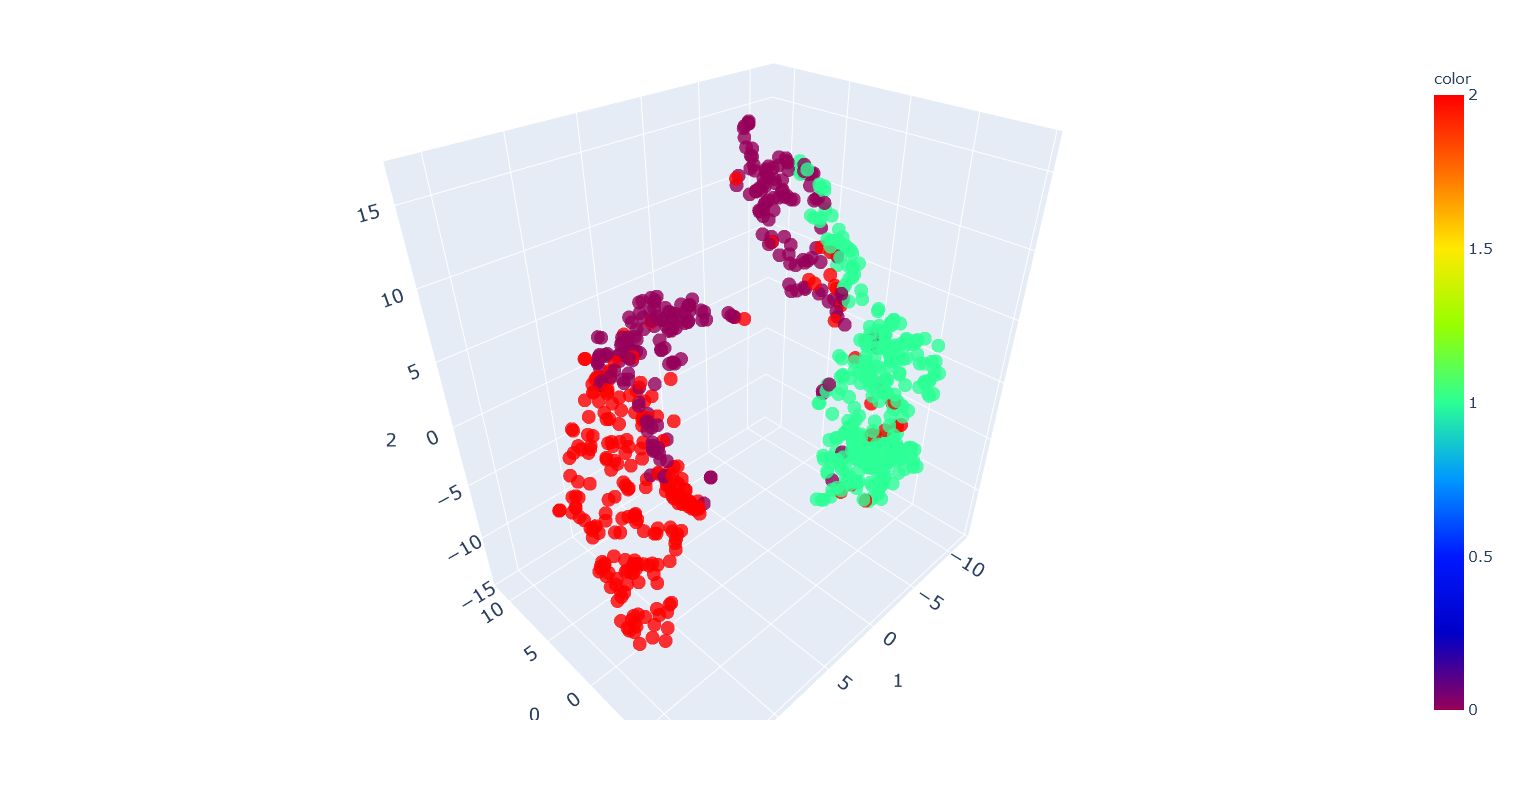

In [89]:
graph = px.scatter_3d(tsne_PQ, x = 0, y= 1, z = 2,
               color = kk.labels_,
               opacity = 0.8,
               width = 800, height = 800,
               color_continuous_scale = 'rainbow'
               )
zoom =1
camera = dict(
        up=dict(x=0, y=0, z=1),
        center=dict(x=0, y=0, z=0),
        eye=dict(x=-1.25*zoom, y=1.25*zoom, z=1.25*zoom)
    )
graph.update_layout(scene_camera = camera, font_size = 15)
graph.write_image(fig_dir + 'kmeans_tsne.pdf')
graph.show()

In [1]:
print('Clústers (euler): ', neighbours[eucl_index])
print('Clústers (dtw): ', neighbours[dtw_index])

Clústers (euler):  3
Clústers (dtw):  3


## Birch <a id = "birch"></a>

In [27]:
birch = Birch(n_clusters = None)

In [28]:
nn = np.arange(2,10)
sil = np.zeros((3, nn.shape[0]))
cal = np.zeros((3, nn.shape[0]))

for i, n in enumerate(nn):
    for j, dd in enumerate([dd_eucl, dd_dtw, dd_gak]):
        birch = Birch(n_clusters = n)
        classes = birch.fit_predict(PQ_fitted.values)
        sil[j,i] =  mm.silhouette_score(dd, labels = classes)
        cal[j,i] =  mm.calinski_harabasz_score(PQ_fitted, labels = classes)

In [32]:
scores = scaler.fit_transform(sil) * sil_factor + scaler.fit_transform(cal) * cal_factor
scores = scores.reshape(scores.shape[:-1])

In [33]:
eucl_index = np.where(scores[0] == scores.max(axis = 1)[0])[-1][0]
dtw_index = np.where(scores[1] == scores.max(axis = 1)[1])[-1][0]
gak_index = np.where(scores[2] == scores.max(axis = 1)[2])[-1][0]

In [ ]:
clust_s['birch'] = [sil[0, eucl_index], sil[1, dtw_index], sil[2, gak_index]]
clust_c['birch'] = [cal[0, eucl_index], cal[1, dtw_index], cal[2, gak_index]]


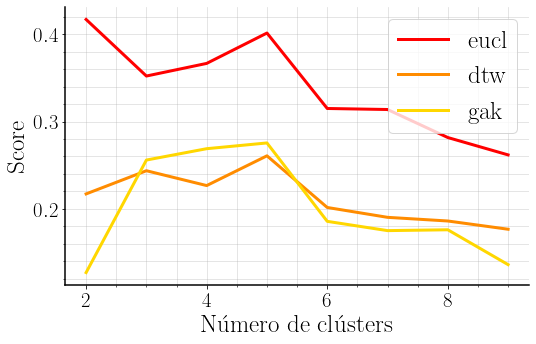

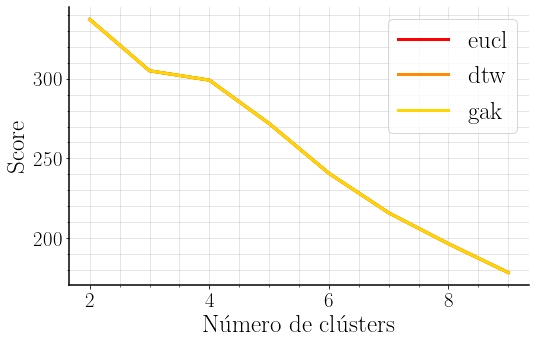

In [35]:
fig_sil, ax_sil = plt.subplots()

ax_sil.plot(nn, sil[0], label = "eucl")
ax_sil.plot(nn, sil[1], label = "dtw")
ax_sil.plot(nn, sil[2], label = "gak")
ax_sil.set_xlabel('Número de clústers')
ax_sil.set_ylabel('Score')
ax_sil.legend()

fig_cal, ax_cal = plt.subplots()

ax_cal.plot(nn, cal[0], label = "eucl")
ax_cal.plot(nn, cal[1], label = "dtw")
ax_cal.plot(nn, cal[2], label = "gak")
ax_cal.set_xlabel('Número de clústers')
ax_cal.set_ylabel('Score')
ax_cal.legend()

fig_sil.savefig(fig_dir + 'birch_sil.pdf')
fig_cal.savefig(fig_dir + 'birch_cal.pdf')

In [139]:
params_birch = pd.DataFrame([nn[eucl_index], nn[dtw_index], nn[gak_index]], index = ['eucl', 'dtw', 'gak'], columns = ['nn'])
params_birch

nn
eucl   2
dtw    5
gak    4

Estos son las tablas resultates de cada tipo de score para cada métrica y algoritmo:

In [97]:
clust_s

markov    kmeans     birch
eucl  0.288605  0.280054  0.416687
dtw   0.183786  0.230174  0.260769
gak   0.153714       NaN  0.268920

In [98]:
clust_c

markov      kmeans       birch
eucl  234.706201  590.202352  337.184669
dtw   234.706201  361.797847  271.892600
gak   234.706201         NaN  299.103373

## Método experimental <a id="experimento"></a>

<div class = "alert alert-block alert-info">
Las representaciones de las series usan los datos completos.
</div>

Completamos el desarrollo con una combinación de cada categoría para el análisis de los datos completos.

In [124]:
clust = OPTICS(min_samples=50, xi=0.05, min_cluster_size=.1, metric = "precomputed")
clust.fit(dd_eucl_all)
classes = np.array([clust.reachability_ < q for q in np.quantile(a = clust.reachability_[~np.isinf(clust.reachability_)], q = qq)])

In [125]:
score_eucl_sil = [mm.silhouette_score(dd_eucl_all, labels = class_eucl) for class_eucl in classes]
score_eucl_cal = [mm.calinski_harabasz_score(PQ_fitted_all, labels = class_eucl) for class_eucl in classes]

In [126]:
score_eucl = scaler.fit_transform([score_eucl_sil, score_eucl_cal]).reshape(2,-1)
index_eucl = np.where((score_eucl[0] * sil_factor + score_eucl[1] * cal_factor) == (score_eucl[0] * sil_factor + score_eucl[1] * cal_factor).max())[0][-1]

In [129]:
anomalies = clust.reachability_ >= np.quantile(clust.reachability_[~np.isinf(clust.reachability_)], q = qq[index_eucl])
anomalies[np.isinf(clust.reachability_)] = True

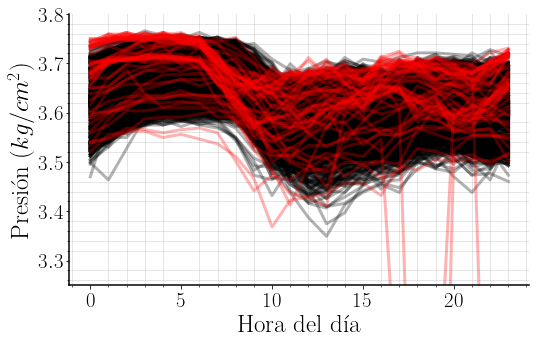

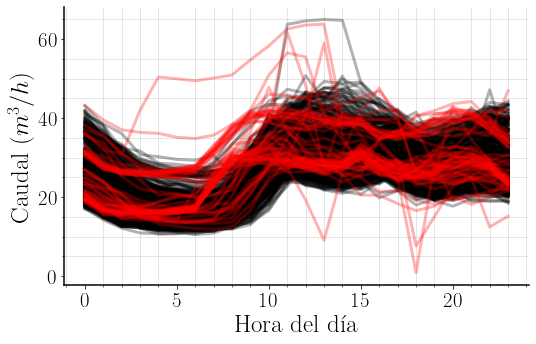

In [145]:
fig_P, ax_P = plt.subplots()
dt_D_all.loc[~anomalies, 'P'].transpose().plot(
    c = color_disc[1], legend = False, alpha = 0.3, ax = ax_P)
dt_D_all.loc[anomalies, 'P'].transpose().plot(
    c = color_disc[0], legend = False, alpha = 0.3, ax = ax_P)
ax_P.grid()
ax_P.set_xlabel('Hora del día')
ax_P.set_ylabel('Presión ($kg/cm^2$)')
ax_P.set_ylim(3.25,3.8)

fig_Q, ax_Q = plt.subplots()
dt_D_all.loc[~anomalies, 'Q'].transpose().plot(
    c = color_disc[1], legend = False, alpha = 0.3, ax = ax_Q)
dt_D_all.loc[anomalies, 'Q'].transpose().plot(
    c = color_disc[0], legend = False, alpha = 0.3, ax = ax_Q)
ax_Q.grid()
ax_Q.set_xlabel('Hora del día')
ax_Q.set_ylabel('Caudal ($m^3/h$)')

fig_P.savefig(fig_dir + 'experiment_P_anomaly.pdf')
fig_Q.savefig(fig_dir + 'experiment_Q_anomaly.pdf')

Agrupamos por clases:

In [238]:
birch = Birch(n_clusters = 5)
classes = birch.fit_predict(PQ_fitted_all[~anomalies].values)

In [210]:
tsne = TSNE(learning_rate = 100.0, perplexity = 20.0, n_components = 3, random_state = 42, n_jobs = -1)
tsne_PQ = tsne.fit_transform(dd_eucl_all)
tsne_PQ = pd.DataFrame(tsne_PQ, index = PQ_fitted_all.index,
             columns = pd.Index([0, 1, 2], name = 'coord'))
tsne_PQ['fecha'] = PQ_fitted_all.index.strftime('%Y/%m/%d')

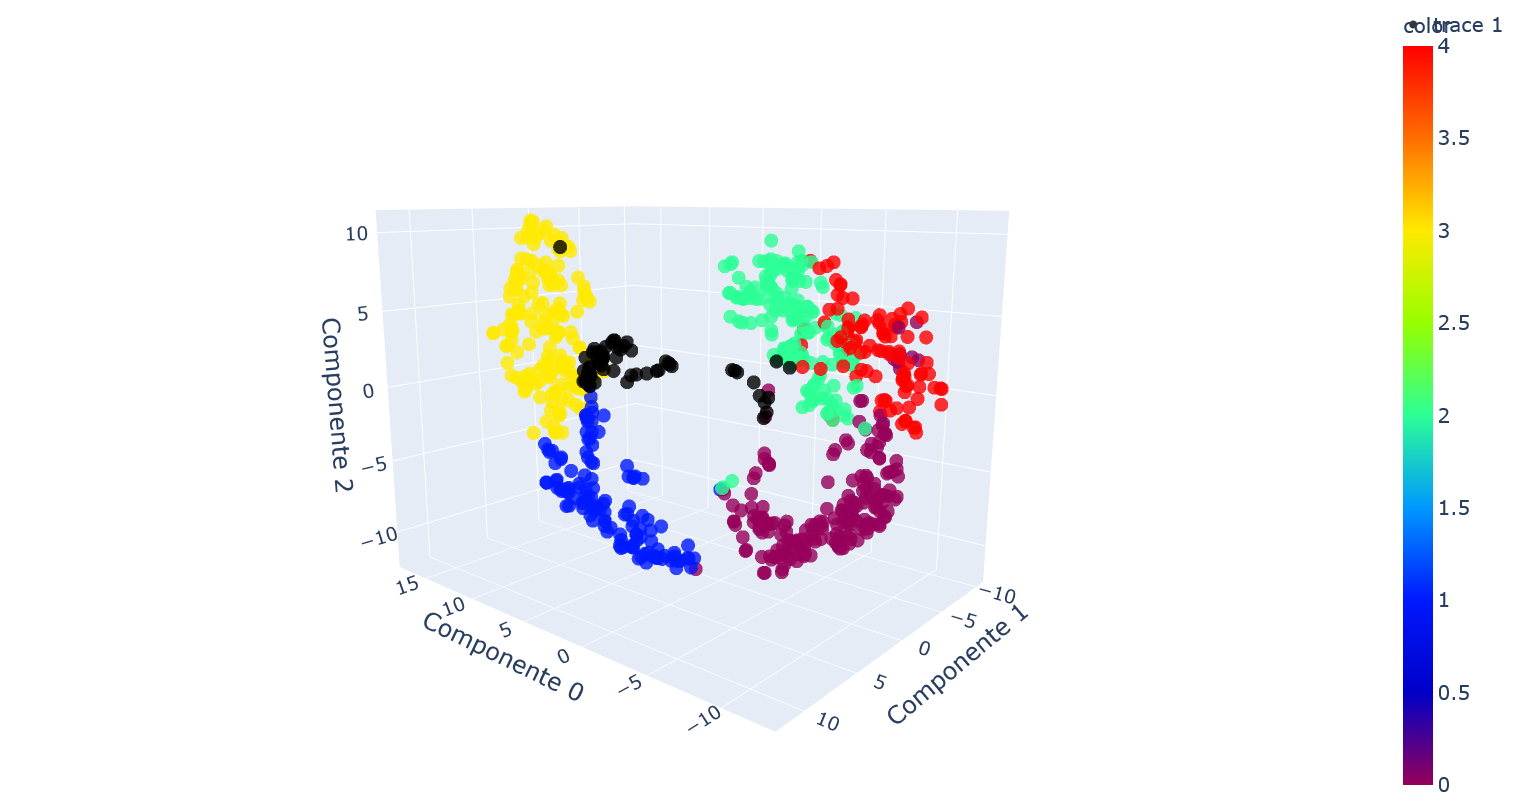

In [239]:
graph = give_drawing(tsne_PQ[~anomalies], classes, x_cam = -1.5, y_cam = 1.75, z_cam = 0.5, zoom = 1., hovertext = "fecha")

anomalies_graph = go.Scatter3d(x = tsne_PQ.iloc[anomalies, 0],
                        y = tsne_PQ.iloc[anomalies, 1],
                        z = tsne_PQ.iloc[anomalies, 2],
        mode = "markers",
        marker = dict(
            color = "black",
            opacity = 0.8
        ))
graph.add_traces(anomalies_graph)
graph.write_image(fig_dir + 'experiment_tsne_classes.pdf')
graph.show()

Aparece una concentración de puntos de la misma forma que en las figuras anteriores. Parece que una opción mejor será LOF:

In [223]:
clf = LocalOutlierFactor(n_neighbors=89, contamination=0.056898, metric = "precomputed")
anomalies_lof = clf.fit_predict(dd_eucl_all) == -1

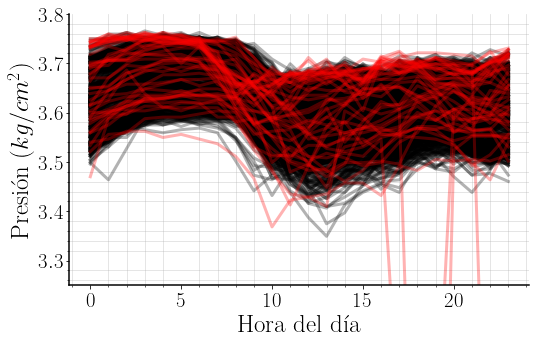

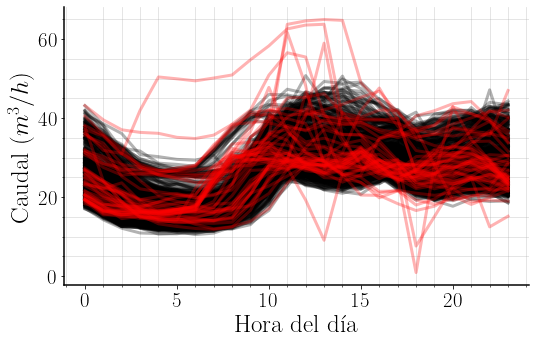

In [225]:
fig_P, ax_P = plt.subplots()
dt_D_all.loc[~anomalies_lof, 'P'].transpose().plot(
    c = color_disc[1], legend = False, alpha = 0.3, ax = ax_P)
dt_D_all.loc[anomalies_lof, 'P'].transpose().plot(
    c = color_disc[0], legend = False, alpha = 0.3, ax = ax_P)
ax_P.grid()
ax_P.set_xlabel('Hora del día')
ax_P.set_ylabel('Presión ($kg/cm^2$)')
ax_P.set_ylim(3.25,3.8)

fig_Q, ax_Q = plt.subplots()
dt_D_all.loc[~anomalies_lof, 'Q'].transpose().plot(
    c = color_disc[1], legend = False, alpha = 0.3, ax = ax_Q)
dt_D_all.loc[anomalies_lof, 'Q'].transpose().plot(
    c = color_disc[0], legend = False, alpha = 0.3, ax = ax_Q)
ax_Q.grid()
ax_Q.set_xlabel('Hora del día')
ax_Q.set_ylabel('Caudal ($m^3/h$)')

fig_P.savefig(fig_dir + 'experiment_P_anomaly_lof.pdf')
fig_Q.savefig(fig_dir + 'experiment_Q_anomaly_lof.pdf')

In [236]:
birch = Birch(n_clusters = 5)
classes = birch.fit_predict(PQ_fitted_all[~anomalies_lof].values)

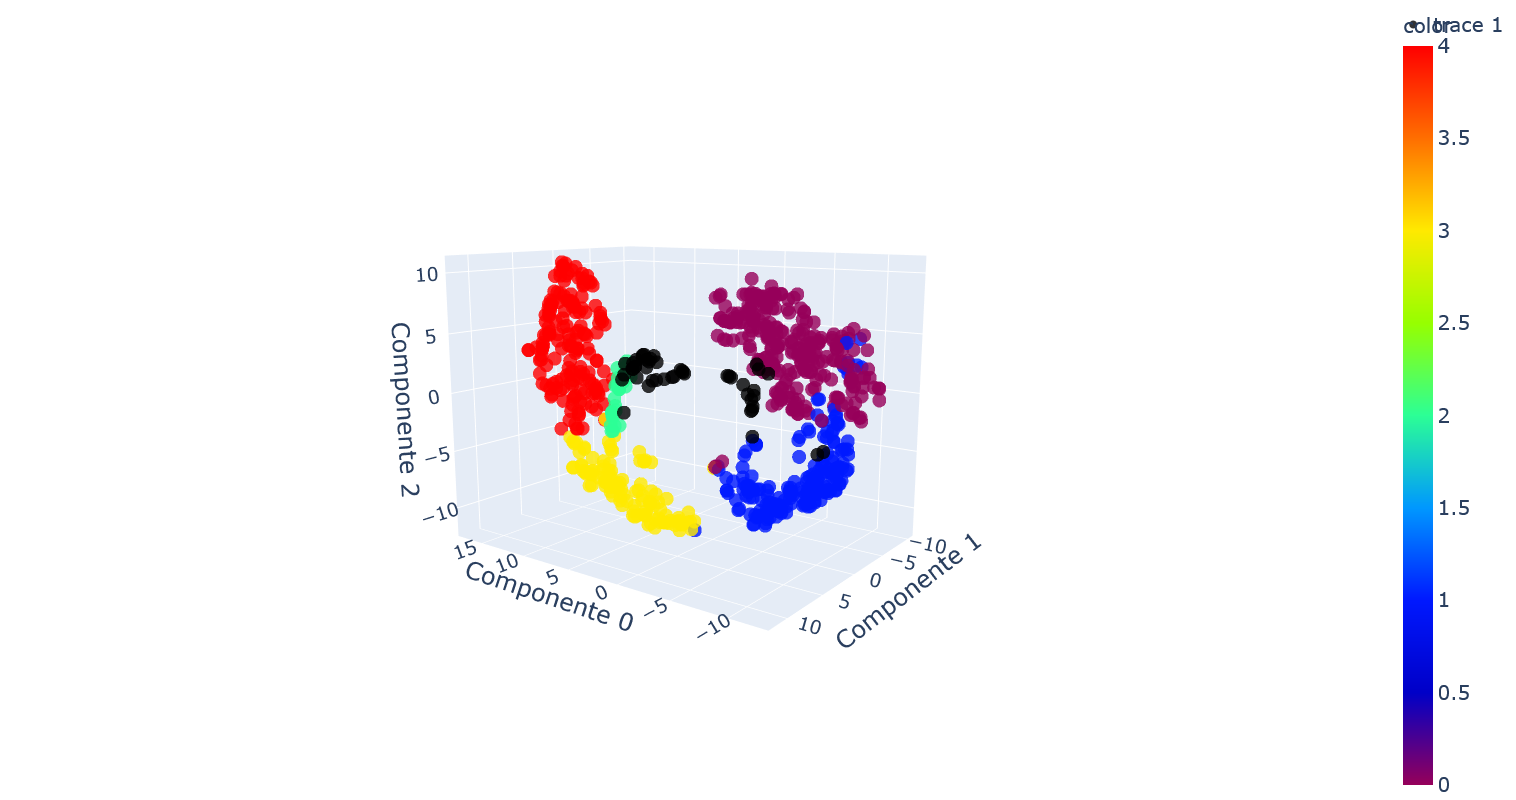

In [237]:
graph = give_drawing(tsne_PQ[~anomalies_lof], classes, x_cam = -1.5, y_cam = 1.75, z_cam = 0.5, zoom = 1., hovertext = "fecha")

anomalies_graph = go.Scatter3d(x = tsne_PQ.iloc[anomalies_lof, 0],
                        y = tsne_PQ.iloc[anomalies_lof, 1],
                        z = tsne_PQ.iloc[anomalies_lof, 2],
        mode = "markers",
        marker = dict(
            color = "black",
            opacity = 0.8
        ))
graph.add_traces(anomalies_graph)
graph.write_image(fig_dir + 'experiment_tsne_classes_lof.pdf')
graph.show()

Encontramos que LOF detecta el clúster de baja densidad y no recoge los datos como anomalías. Por lo tanto, una comprobación visual ha ayudado a determinar el mejor procedimiento y los índices sirven como apoyo al científico de datos.